# Genomic surveillance analysis in Germany

In [73]:
import matplotlib.pyplot as plt
import numpy as np
import numpyro as npy
import numpyro.distributions as dist
import pandas as pd
from jax import random
import geopandas as gpd
import genomicsurveillance as gs ## misc branch on github

assert npy.__version__.startswith("0.8.0")
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams.update({'axes.grid': True,
                     'grid.linestyle': ':',
                     'axes.spines.bottom': False,
          'axes.spines.left': False,
          'axes.spines.right': False,
          'axes.spines.top': False})

## Download data
### Map
With zip codes for geo matching

In [74]:
#plz = gpd.read_file("https://opendata.arcgis.com/datasets/5b203df4357844c8a6715d7d411a8341_0.geojson")
plz = gpd.read_file("data/5b203df4357844c8a6715d7d411a8341_0.geojson")
bland = plz.set_index("plz")['bundesland']

### Sequences
From RKI's Github

In [75]:
! bash scripts/pipeline.sh

+ bash scripts/download_data.sh
+ mkdir -p data/compressed
+ curl -L https://github.com/robert-koch-institut/SARS-CoV-2-Sequenzdaten_aus_Deutschland/raw/master/SARS-CoV-2-Sequenzdaten_Deutschland.csv.xz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   210  100   210    0     0    534      0 --:--:-- --:--:-- --:--:--   532
100 37.8M  100 37.8M    0     0  8455k      0  0:00:04  0:00:04 --:--:-- 13.2M
+ curl -L https://github.com/robert-koch-institut/SARS-CoV-2-Sequenzdaten_aus_Deutschland/raw/master/SARS-CoV-2-Entwicklungslinien_Deutschland.csv.xz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   216  100   216    0     0    435      0 --:--:-- --:--:-- --:--:--   435
100 14.8M  100 14.8M    0     0  1729k      0  0:00:08  0:00:08 --:--:-- 2762k--:--  0:00:01 -

In [76]:
df = pd.read_csv(
    'data/meta_lineages.csv',
    index_col=0,
    parse_dates=[1,3],
    infer_datetime_format=True,
    cache_dates=True,
    dtype = {'SEQ_REASON': 'category',
             'SENDING_LAB_PC': 'category',
             'SEQUENCING_LAB_PC': 'category',
             'lineage': 'category',
             'scorpio_call': 'category'
             }
)
df.rename(columns={
    'DATE_DRAW': 'date',
    'PROCESSING_DATE': 'processing_date',
    'SEQ_REASON': 'reason',
    'SENDING_LAB_PC': 'sending_pc',
    'SEQUENCING_LAB_PC': 'sequencing_pc',
    'lineage': 'lineage',
    'scorpio_call': 'scorpio'
    },
    inplace=True
)

In [77]:
df = df[~ pd.isna(df.sending_pc)]
df.sending_pc = df.sending_pc.cat.rename_categories({x:f"{float(x):05.0f}" for x in df.sending_pc.cat.categories}) # = df.sending_pc.astype('str').astype('category')


In [78]:

df = df.merge(bland, left_on='sending_pc', right_index=True)#.dropna()


In [79]:
df.reason.value_counts()

N                             319618
X                             226414
A[B.1.1.7]                     35832
A[B.1.617.2]                   35539
Y                              25916
                               ...  
A[KONTAKTMITENGL.MUTATION]         0
A[B1.627.2]                        0
A[E484E/N501N/P681R]               0
A[E484K/N501Y/P681R]               0
A[B1.1.529]                        0
Name: reason, Length: 210, dtype: int64

In [80]:
import re

In [81]:
df

date reason  \
IMS_ID                                                                 
IMS-10294-CVDP-00001                               2021-01-14      X   
IMS-10294-CVDP-00325                               2020-11-08      X   
IMS-10294-CVDP-00326                               2020-11-08      X   
IMS-10294-CVDP-00327                               2020-11-08      X   
IMS-10294-CVDP-00329                               2020-11-09      X   
...                                                       ...    ...   
IMS-10116-CVDP-332653ED-6FA8-45E1-8B77-32C8432E... 2022-03-04      N   
IMS-10116-CVDP-6289E96F-AB4E-44DF-AACC-070D9E33... 2022-03-04      N   
IMS-10116-CVDP-2802D128-1F54-4279-9582-A7CAD93A... 2022-03-04      N   
IMS-10116-CVDP-C7A62ACF-2F17-4246-9348-F0E9E0C6... 2022-03-04      N   
IMS-10116-CVDP-497C8EFD-0D95-4517-BC1C-4633B9A5... 2022-03-04      N   

                                                   processing_date sending_pc  \
IMS_ID                                                                          
IMS-10294-CVDP-00001                                    2021-01-25      40225   
IMS-10294-CVDP-00325                                    2021-02-14      40225   
IMS-10294-CVDP-00326                                    2021-02-14      40225   
IMS-10294-CVDP-00327                                    2021-02-14      40225   
IMS-10294-CVDP-00329                                    2021-02-14      40225   
...                                                            ...        ...   
IMS-10116-CVDP-332653ED-6FA8-45E1-8B77-32C8432E...      2022-03-12      37081   
IMS-10116-CVDP-6289E96F-AB4E-44DF-AACC-070D9E33...      2022-03-12      37081   
IMS-10116-CVDP-2802D128-1F54-4279-9582-A7CAD93A...      2022-03-12      37081   
IMS-10116-CVDP-C7A62ACF-2F17-4246-9348-F0E9E0C6...      2022-03-12      37081   
IMS-10116-CVDP-497C8EFD-0D95-4517-BC1C-4633B9A5...      2022-03-12      37081   

                                                   sequencing_pc    lineage  \
IMS_ID                                                                        
IMS-10294-CVDP-00001                                     40225.0  B.1.1.297   
IMS-10294-CVDP-00325                                     40225.0    B.1.221   
IMS-10294-CVDP-00326                                     40225.0    B.1.160   
IMS-10294-CVDP-00327                                     40225.0    B.1.258   
IMS-10294-CVDP-00329                                     40225.0  B.1.1.521   
...                                                          ...        ...   
IMS-10116-CVDP-332653ED-6FA8-45E1-8B77-32C8432E...       69126.0       BA.1   
IMS-10116-CVDP-6289E96F-AB4E-44DF-AACC-070D9E33...       69126.0     BA.1.1   
IMS-10116-CVDP-2802D128-1F54-4279-9582-A7CAD93A...       69126.0       BA.2   
IMS-10116-CVDP-C7A62ACF-2F17-4246-9348-F0E9E0C6...       69126.0     BA.1.1   
IMS-10116-CVDP-497C8EFD-0D95-4517-BC1C-4633B9A5...       69126.0       BA.2   

                                                                scorpio  \
IMS_ID                                                                    
IMS-10294-CVDP-00001                                                NaN   
IMS-10294-CVDP-00325                                                NaN   
IMS-10294-CVDP-00326                                                NaN   
IMS-10294-CVDP-00327                                                NaN   
IMS-10294-CVDP-00329                                                NaN   
...                                                                 ...   
IMS-10116-CVDP-332653ED-6FA8-45E1-8B77-32C8432E...  Omicron (BA.1-like)   
IMS-10116-CVDP-6289E96F-AB4E-44DF-AACC-070D9E33...  Omicron (BA.1-like)   
IMS-10116-CVDP-2802D128-1F54-4279-9582-A7CAD93A...  Omicron (BA.2-like)   
IMS-10116-CVDP-C7A62ACF-2F17-4246-9348-F0E9E0C6...  Omicron (BA.1-like)   
IMS-10116-CVDP-497C8EFD-0D95-4517-BC1C-4633B9A5...  Omicron (BA.2-like)   

                                                             b

In [82]:
df.lineage[df.date > np.datetime64("today") - np.timedelta64(30, "D")].cat.remove_unused_categories().value_counts()

BA.2          24303
BA.1.1        11726
BA.1           5374
None            622
B.1              86
B.1.177.86       13
BA.3             10
B.1.617.2         8
B.1.575.1         5
AZ.2              5
B.1.2             3
AY.126            2
AY.13             2
AY.4              2
B.1.1             2
AY.121            2
AY.129            1
AY.43             1
AY.127            1
AY.122            1
AY.21             1
AY.4.2.3          1
AY.7.1            1
AY.121.1          1
Name: lineage, dtype: int64

In [83]:
import re

In [84]:
d = df.loc[df.date >= "2021-11-01",:]
d = d[d.reason.isin(['N','X'])]
d = d[d.lineage != "None"]
d.lineage = d.lineage.cat.add_categories(['Other'])
#d.lineage[d.lineage.isna()] = 'Other'
#d.loc[~d.lineage.isin(['BA.1','BA.1.1','BA.2','BA.3','B.1.1.529']),"lineage"] = "Delta/Other"
d.lineage.iloc[d.lineage.apply(lambda x: re.match("AY",x) is not None).astype("Bool")] = "B.1.617.2"
d.loc[~d.lineage.isin(['BA.1','BA.1.1','BA.2','BA.3','B.1.1.529','B.1.617.2']),"lineage"] = "Other"
genomes = pd.crosstab(index=[d.bundesland, d.date], columns=d.lineage.cat.remove_unused_categories(), dropna=False).fillna(0)
#genomes.loc["Baden-Württemberg"]
genomes = genomes.iloc[:,[1,2,3,4,5,0]]
genomes

lineage                       BA.1  BA.1.1  BA.2  BA.3  Other  B.1.617.2
bundesland        date                                                  
Baden-Württemberg 2021-11-01     0       0     0     0      0        142
                  2021-11-02     0       0     0     0      0        350
                  2021-11-03     0       0     0     0      0        704
                  2021-11-04     0       0     0     0      0       1044
                  2021-11-05     0       0     0     0      0       1210
...                            ...     ...   ...   ...    ...        ...
Thüringen         2022-03-10     0       0     0     0      0          0
                  2022-03-12     0       0     0     0      0          0
                  2022-03-14     0       0     0     0      0          0
                  2022-03-15     0       0     0     0      0          0
                  2022-03-16     0       0     0     0      0          0

[2144 rows x 6 columns]

In [85]:
genomes.sum(level=0)

lineage                  BA.1  BA.1.1   BA.2  BA.3  Other  B.1.617.2
bundesland                                                          
Baden-Württemberg       16383   19349  11803     6     31      41415
Bayern                   2955    4694   4831     0     29       6204
Berlin                    718     734    982     0      5       2888
Brandenburg               935    1392   1157     1      0       2851
Bremen                    209     396    110     0      5        837
Hamburg                  4021    3518   1622     3     23       3769
Hessen                    985    1576    663     2      1       1643
Mecklenburg-Vorpommern    578     587    552     0      0       2824
Niedersachsen             977    1156    705     0      6       3018
Nordrhein-Westfalen     19609   21008  12877    15    161      26429
Rheinland-Pfalz           319     360    125     0      2       1510
Saarland                  782    1161    407     0      4       1777
Sachsen                  5084    7439   3369     2     32      15123
Sachsen-Anhalt           1622     476    704     3      0       3003
Schleswig-Holstein       3180    4248   2464     4      2       3907
Thüringen                 330     626    261     0      8       1703

In [86]:
genomes.index.levels[0]

Index(['Baden-Württemberg', 'Bayern', 'Berlin', 'Brandenburg', 'Bremen',
       'Hamburg', 'Hessen', 'Mecklenburg-Vorpommern', 'Niedersachsen',
       'Nordrhein-Westfalen', 'Rheinland-Pfalz', 'Saarland', 'Sachsen',
       'Sachsen-Anhalt', 'Schleswig-Holstein', 'Thüringen'],
      dtype='object', name='bundesland')

In [87]:
G = genomes.values.reshape([len(genomes.index.levels[0]), len(genomes.index.levels[1]), -1])

### Cases
Also from RKI

In [88]:
cases_raw = pd.read_csv("https://media.githubusercontent.com/media/robert-koch-institut/SARS-CoV-2_Infektionen_in_Deutschland/master/Aktuell_Deutschland_SarsCov2_Infektionen.csv",  index_col=[0,1,2,4], parse_dates=True)

In [89]:
cases_raw

Meldedatum  \
IdLandkreis Altersgruppe Geschlecht Refdatum                 
1001        A15-A34      M          2020-01-19  2020-10-28   
                                    2020-03-13  2020-03-19   
                                    2020-03-13  2020-03-21   
                                    2020-03-16  2020-03-14   
                                    2020-03-16  2020-03-19   
...                                                    ...   
16077       A15-A34      W          2022-03-18  2022-03-18   
            A35-A59      W          2022-03-18  2022-03-18   
            A60-A79      W          2022-03-18  2022-03-18   
            A80+         W          2022-03-18  2022-03-18   
            unbekannt    W          2022-03-18  2022-03-18   

                                                IstErkrankungsbeginn  \
IdLandkreis Altersgruppe Geschlecht Refdatum                           
1001        A15-A34      M          2020-01-19                     1   
                                    2020-03-13                     1   
                                    2020-03-13                     1   
                                    2020-03-16                     1   
                                    2020-03-16                     1   
...                                                              ...   
16077       A15-A34      W          2022-03-18                     0   
            A35-A59      W          2022-03-18                     0   
            A60-A79      W          2022-03-18                     0   
            A80+         W          2022-03-18                     0   
            unbekannt    W          2022-03-18                     0   

                                                NeuerFall  NeuerTodesfall  \
IdLandkreis Altersgruppe Geschlecht Refdatum                                
1001        A15-A34      M          2020-01-19          0              -9   
                                    2020-03-13          0              -9   
                                    2020-03-13          0              -9   
                                    2020-03-16          0              -9   
                                    2020-03-16          0              -9   
...                                                   ...             ...   
16077       A15-A34      W          2022-03-18          1              -9   
            A35-A59      W          2022-03-18          1              -9   
            A60-A79      W          2022-03-18          1              -9   
            A80+         W          2022-03-18          1              -9   
            unbekannt    W          2022-03-18          1              -9   

                                                NeuGenesen  AnzahlFall  \
IdLandkreis Altersgruppe Geschlecht Refdatum                             
1001        A15-A34      M          2020-01-19           0           1   
                                    2020-03-13           0           1   
                                    2020-03-13           0           1   
                                    2020-03-16           0           1   
                                    2020-03-16           0           1   
...                                                    ...         ...   
16077       A15-A34      W          2022-03-18          -9          33   
            A35-A59      W          2022-03-18          -9          69   
            A60-A79      W          2022-03-18          -9          30   
            A80+         W          2022-03-18          -9           7   
            unbekannt    W          2022-03-18          -9           2   

                                                AnzahlTodesfall  AnzahlGenesen  
IdLandkreis Altersgruppe Geschlecht Refdatum                                    
1001        A15-A34      M          2020-01-19                0              1  
                                    2020-03-13                0              1  
               

### Registration delays

In [90]:
f = cases_raw.reset_index(level=3)[['Refdatum','Meldedatum','AnzahlFall'] ].reset_index()
f['Delta'] = np.clip(pd.to_datetime(f['Meldedatum']) - f['Refdatum'], np.timedelta64(0,"D"), np.timedelta64(10,"D"))
f['bundesland'] = (f.IdLandkreis/1000).astype("int")

f= f.set_index(["bundesland","IdLandkreis","Altersgruppe","Geschlecht","Refdatum","Delta"]).sum(level=[0,4,5]).sort_index()
f = f.unstack(level=2)["AnzahlFall"].sort_index().loc[:,"2022-02-01":,:]#.loc[:,"2021-11-01":]
f /= f.sum(1).values[:,np.newaxis]

<AxesSubplot:xlabel='bundesland,Refdatum'>

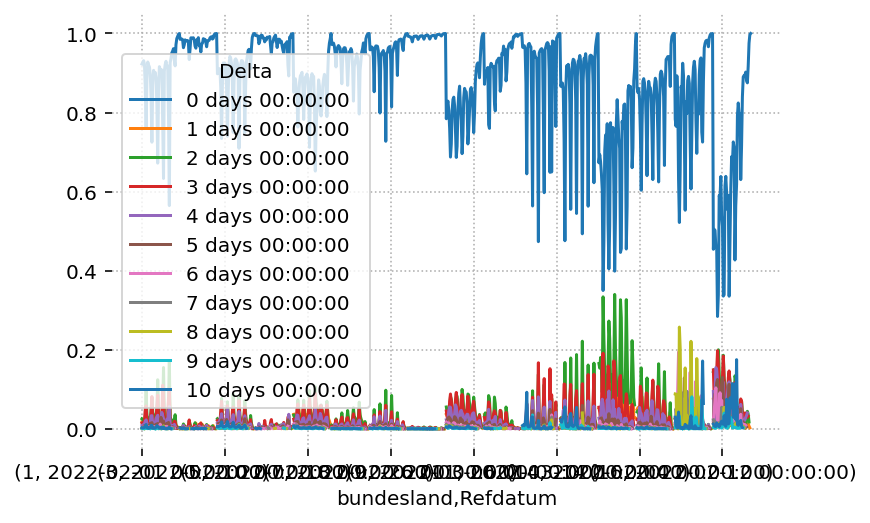

In [91]:
f.plot()

In [92]:
f['weekday'] = f.reset_index()['Refdatum'].dt.strftime("%a").values

In [93]:
f = f.reset_index().set_index(["bundesland","Refdatum","weekday"]).cumsum(1).mean(level=[0,2]).fillna(1)

In [94]:
f.loc[1]

Delta    0 days 00:00:00  1 days 00:00:00  2 days 00:00:00  3 days 00:00:00  \
weekday                                                                       
Tue             0.931270         0.948490         0.972406         0.986126   
Wed             0.931671         0.950903         0.973830         0.979087   
Thu             0.932394         0.951568         0.958721         0.963518   
Fri             0.927628         0.928027         0.937136         0.961437   
Sat             0.835349         0.845549         0.892517         0.950853   
Sun             0.712152         0.760840         0.871081         0.941717   
Mon             0.902331         0.927306         0.960279         0.979495   

Delta    4 days 00:00:00  5 days 00:00:00  6 days 00:00:00  7 days 00:00:00  \
weekday                                                                       
Tue             0.988896         0.990251         0.994314         0.996502   
Wed             0.981698         0.989543         0.994890         0.997114   
Thu             0.978878         0.991266         0.995700         0.997507   
Fri             0.981831         0.991092         0.994432         0.996318   
Sat             0.978879         0.988243         0.992103         0.991811   
Sun             0.971505         0.982830         0.983724         0.985558   
Mon             0.989388         0.990482         0.991890         0.994727   

Delta    8 days 00:00:00  9 days 00:00:00  10 days 00:00:00  
weekday                                                      
Tue             0.997581         0.998203               1.0  
Wed             0.998248         0.998661               1.0  
Thu             0.998005         0.998318               1.0  
Fri             0.996313         0.996562               1.0  
Sat             0.993305         0.994670               1.0  
Sun             0.990566         0.993137               1.0  
Mon             0.996669         0.998019               1.0

In [95]:
reporting_lag = np.array([f.loc[:,d.strftime("%a"),:].iloc[:,(cases_raw.index.levels[3][-1]-d).days] for d in cases_raw.index.levels[3][-9:]]).T

In [96]:
s="""01  Schleswig-Holstein
02  Hamburg
03  Niedersachsen
04  Bremen
05  Nordrhein-Westfalen
06  Hessen
07  Rheinland-Pfalz
08  Baden-Württemberg
09  Bayern
10  Saarland
11  Berlin
12  Brandenburg
13  Mecklenburg-Vorpommern
14  Sachsen
15  Sachsen-Anhalt
16  Thüringen"""
b={int(x.split()[0]): x.split()[1] for x in s.split("\n")}

In [97]:
current_lag = pd.DataFrame(reporting_lag, index=np.arange(1,17)).rename(index=b).sort_index()
current_lag

0         1         2         3         4  \
Baden-Württemberg       0.999830  0.999784  0.999613  0.998973  0.998724   
Bayern                  0.997550  0.995097  0.990902  0.982318  0.969968   
Berlin                  0.996736  0.995652  0.980935  0.943232  0.991740   
Brandenburg             0.993085  0.991050  0.980667  0.951174  0.983295   
Bremen                  1.000000  1.000000  1.000000  0.998361  0.996408   
Hamburg                 0.998881  0.998883  0.998234  0.997812  0.996818   
Hessen                  0.999363  0.999034  0.998140  0.994655  0.994512   
Mecklenburg-Vorpommern  0.998029  0.996524  0.995539  0.989315  0.981451   
Niedersachsen           0.995340  0.993622  0.987206  0.966888  0.973304   
Nordrhein-Westfalen     0.997866  0.996214  0.993228  0.986410  0.981815   
Rheinland-Pfalz         0.999256  0.998582  0.996946  0.988930  0.994170   
Saarland                0.999034  0.999110  0.998354  0.995401  0.989933   
Sachsen                 0.998850  0.998060  0.996088  0.991785  0.990263   
Sachsen-Anhalt          0.998348  0.997049  0.957474  0.793508  0.880472   
Schleswig-Holstein      0.998005  0.996318  0.992103  0.982830  0.989388   
Thüringen               0.961491  0.975313  0.971050  0.919211  0.887893   

                               5         6         7         8  
Baden-Württemberg       0.998329  0.997585  0.996467  0.995296  
Bayern                  0.956711  0.937834  0.907265  0.865587  
Berlin                  0.974457  0.983858  0.975758  0.966959  
Brandenburg             0.979746  0.968812  0.953604  0.925812  
Bremen                  0.994419  0.993282  0.987471  0.990007  
Hamburg                 0.993417  0.991907  0.986248  0.980965  
Hessen                  0.992779  0.987192  0.978418  0.964906  
Mecklenburg-Vorpommern  0.978487  0.948972  0.851635  0.800526  
Niedersachsen           0.975198  0.965689  0.952520  0.938199  
Nordrhein-Westfalen     0.970621  0.954052  0.934438  0.899698  
Rheinland-Pfalz         0.990296  0.984693  0.979712  0.971037  
Saarland                0.988105  0.982156  0.966211  0.953686  
Sachsen                 0.985186  0.967298  0.936694  0.883854  
Sachsen-Anhalt          0.902360  0.916881  0.943770  0.919278  
Schleswig-Holstein      0.986126  0.973830  0.951568  0.927628  
Thüringen               0.866684  0.846723  0.776849  0.709756

In [98]:
cases = cases_raw['AnzahlFall'].sum(level=(0,3)).sort_index()

In [99]:
cases_land = cases.reset_index()
cases_land['bundesland'] = (cases_land.IdLandkreis/1000).astype("int")
cases_land = cases_land.set_index(['bundesland', 'IdLandkreis','Refdatum']).sum(level=(0,2)).sort_index()
cases_land = cases_land.rename(index=b).sort_index()
cases_land = cases_land.loc[:,"2021-11-01":,:].unstack()["AnzahlFall"]#.iloc[:,:-1]
#cases_land.iloc[:,-9:] = (cases_land.iloc[:,-9:] / reporting_lag).astype("int32")
cases_land

Refdatum                2021-11-01  2021-11-02  2021-11-03  2021-11-04  \
bundesland                                                               
Baden-Württemberg           2144.0      2954.0      4426.0      4619.0   
Bayern                      5945.0      7034.0      9174.0      8951.0   
Berlin                      1325.0      1322.0      1440.0      1433.0   
Brandenburg                  814.0       984.0      1073.0      1056.0   
Bremen                        79.0        89.0        69.0        62.0   
Hamburg                      320.0       457.0       540.0       501.0   
Hessen                      1193.0      1595.0      1705.0      1574.0   
Mecklenburg-Vorpommern       418.0       428.0       405.0       317.0   
Niedersachsen               1187.0      1453.0      1673.0      1370.0   
Nordrhein-Westfalen         2549.0      3442.0      4338.0      4339.0   
Rheinland-Pfalz              642.0       990.0      1127.0      1079.0   
Saarland                     127.0       123.0       203.0       230.0   
Sachsen                     2840.0      3669.0      3476.0      3313.0   
Sachsen-Anhalt               647.0       856.0       721.0       738.0   
Schleswig-Holstein           336.0       388.0       367.0       354.0   
Thüringen                   1823.0      1430.0      1426.0      1502.0   

Refdatum                2021-11-05  2021-11-06  2021-11-07  2021-11-08  \
bundesland                                                               
Baden-Württemberg           5070.0      4129.0      2276.0      4390.0   
Bayern                      9242.0      8801.0      7230.0      9346.0   
Berlin                      1450.0       967.0       753.0      2175.0   
Brandenburg                 1185.0      1119.0       981.0      1261.0   
Bremen                        55.0        55.0        31.0        60.0   
Hamburg                      557.0       468.0       412.0       483.0   
Hessen                      1688.0      1313.0      1092.0      1468.0   
Mecklenburg-Vorpommern       544.0       505.0       314.0       528.0   
Niedersachsen               1400.0      1164.0       844.0      1621.0   
Nordrhein-Westfalen         4067.0      3742.0      2952.0      4398.0   
Rheinland-Pfalz             1027.0       808.0       764.0      1082.0   
Saarland                     185.0       214.0       155.0       209.0   
Sachsen                     3467.0      3193.0      2665.0      4437.0   
Sachsen-Anhalt               729.0       658.0       899.0       670.0   
Schleswig-Holstein           435.0       382.0       298.0       449.0   
Thüringen                   1429.0      1755.0      1189.0      1856.0   

Refdatum                2021-11-09  2021-11-10  ...  2022-03-09  2022-03-10  \
bundesland                                      ...                           
Baden-Württemberg           7123.0      7755.0  ...     40614.0     39391.0   
Bayern                     11246.0     12151.0  ...     47500.0     47599.0   
Berlin                      1921.0      2398.0  ...      8232.0      6861.0   
Brandenburg                 1497.0      1687.0  ...      7487.0      7338.0   
Bremen                       143.0        95.0  ...      1464.0      1187.0   
Hamburg                      529.0       571.0  ...      3235.0      3081.0   
Hessen                      1791.0      2067.0  ...     12821.0     11916.0   
Mecklenburg-Vorpommern       597.0       468.0  ...      6496.0      5921.0   
Niedersachsen               1754.0      2165.0  ...     23461.0     24078.0   
Nordrhein-Westfalen         5105.0      5296.0  ...     45940.0     46682.0   
Rheinland-Pfalz             1139.0      1329.0  ...     11324.0     10632.0   
Saarland                     273.0       301.0  ...      3260.0      3509.0   
Sachsen                     5755.0      5987.0  ...     15413.0     13923.0   
Sachsen-Anhalt              1019.0      1178.0  ...      7781.0      7060.0   
Schleswig-Holstein           486.0       542.0  ...      6938.0      6

In [100]:
cases_land.sum(0)

Refdatum
2021-11-01     22389.0
2021-11-02     27214.0
2021-11-03     32163.0
2021-11-04     31438.0
2021-11-05     32530.0
                ...   
2022-03-14    198601.0
2022-03-15    264117.0
2022-03-16    277090.0
2022-03-17    250691.0
2022-03-18    166279.0
Length: 138, dtype: float64

In [101]:
clip = 1
cases_land.iloc[:,-9:] = (cases_land.iloc[:,-9:] / current_lag.values)#.astype("int32")
cases_land.loc["Hamburg"].iloc[-2:] = np.nan
cases_land = cases_land.iloc[:,:cases_land.shape[1]-clip]
cases_land

Refdatum                2021-11-01  2021-11-02  2021-11-03  2021-11-04  \
bundesland                                                               
Baden-Württemberg           2144.0      2954.0      4426.0      4619.0   
Bayern                      5945.0      7034.0      9174.0      8951.0   
Berlin                      1325.0      1322.0      1440.0      1433.0   
Brandenburg                  814.0       984.0      1073.0      1056.0   
Bremen                        79.0        89.0        69.0        62.0   
Hamburg                      320.0       457.0       540.0       501.0   
Hessen                      1193.0      1595.0      1705.0      1574.0   
Mecklenburg-Vorpommern       418.0       428.0       405.0       317.0   
Niedersachsen               1187.0      1453.0      1673.0      1370.0   
Nordrhein-Westfalen         2549.0      3442.0      4338.0      4339.0   
Rheinland-Pfalz              642.0       990.0      1127.0      1079.0   
Saarland                     127.0       123.0       203.0       230.0   
Sachsen                     2840.0      3669.0      3476.0      3313.0   
Sachsen-Anhalt               647.0       856.0       721.0       738.0   
Schleswig-Holstein           336.0       388.0       367.0       354.0   
Thüringen                   1823.0      1430.0      1426.0      1502.0   

Refdatum                2021-11-05  2021-11-06  2021-11-07  2021-11-08  \
bundesland                                                               
Baden-Württemberg           5070.0      4129.0      2276.0      4390.0   
Bayern                      9242.0      8801.0      7230.0      9346.0   
Berlin                      1450.0       967.0       753.0      2175.0   
Brandenburg                 1185.0      1119.0       981.0      1261.0   
Bremen                        55.0        55.0        31.0        60.0   
Hamburg                      557.0       468.0       412.0       483.0   
Hessen                      1688.0      1313.0      1092.0      1468.0   
Mecklenburg-Vorpommern       544.0       505.0       314.0       528.0   
Niedersachsen               1400.0      1164.0       844.0      1621.0   
Nordrhein-Westfalen         4067.0      3742.0      2952.0      4398.0   
Rheinland-Pfalz             1027.0       808.0       764.0      1082.0   
Saarland                     185.0       214.0       155.0       209.0   
Sachsen                     3467.0      3193.0      2665.0      4437.0   
Sachsen-Anhalt               729.0       658.0       899.0       670.0   
Schleswig-Holstein           435.0       382.0       298.0       449.0   
Thüringen                   1429.0      1755.0      1189.0      1856.0   

Refdatum                2021-11-09  2021-11-10  ...  2022-03-08  2022-03-09  \
bundesland                                      ...                           
Baden-Württemberg           7123.0      7755.0  ...     39941.0     40614.0   
Bayern                     11246.0     12151.0  ...     46165.0     47500.0   
Berlin                      1921.0      2398.0  ...       568.0      8232.0   
Brandenburg                 1497.0      1687.0  ...      8221.0      7487.0   
Bremen                       143.0        95.0  ...      1094.0      1464.0   
Hamburg                      529.0       571.0  ...      2882.0      3235.0   
Hessen                      1791.0      2067.0  ...     12099.0     12821.0   
Mecklenburg-Vorpommern       597.0       468.0  ...      7291.0      6496.0   
Niedersachsen               1754.0      2165.0  ...     21334.0     23461.0   
Nordrhein-Westfalen         5105.0      5296.0  ...     46632.0     45940.0   
Rheinland-Pfalz             1139.0      1329.0  ...     12062.0     11324.0   
Saarland                     273.0       301.0  ...      3205.0      3260.0   
Sachsen                     5755.0      5987.0  ...     16217.0     15413.0   
Sachsen-Anhalt              1019.0      1178.0  ...      6126.0      7781.0   
Schleswig-Holstein           486.0       542.0  ...      6652.0      6

In [102]:
C = cases_land.values

### Population data
From Destatis

In [103]:
capita = pd.read_csv("data/12411-0010.csv", index_col=0)["Population"]
capita

Baden-Württemberg         11103043
Bayern                    13140183
Berlin                     3664088
Brandenburg                2531071
Bremen                      680130
Hamburg                    1852478
Hessen                     6293154
Mecklenburg-Vorpommern     1610774
Niedersachsen              8003421
Nordrhein-Westfalen       17925570
Rheinland-Pfalz            4098391
Saarland                    983991
Sachsen                    4056941
Sachsen-Anhalt             2180684
Schleswig-Holstein         2910875
Thüringen                  2120237
Name: Population, dtype: int64

In [104]:
131 % 10

1

## Modeling
### Basis functions

In [223]:
from genomicsurveillance.misc import fused_basis
n = C.shape[1]+clip
#B0 = fused_basis(n, inc=10, fuse=4, pad=28 - n % 10) ## cubic spline basis every 10d, last 4 linearly fused to avoid wriggles 
B0 = fused_basis(n+2, inc=7, fuse=5, pad=30 - n % 7)## cubic spline basis every 7d, last 5 linearly fused to avoid wriggles 
B0 = np.stack([B0[0,2:,:],B0[1,:-2,:]])

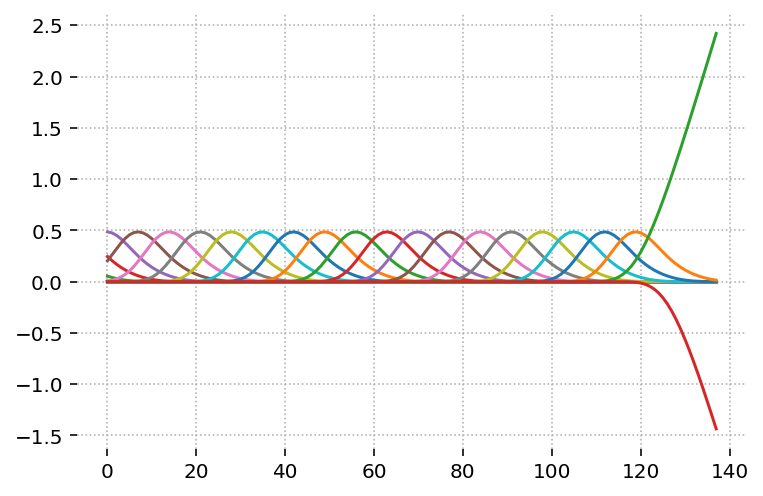

In [224]:
for i in range(B0.shape[-1]):
    plt.plot(B0[0,:,i])

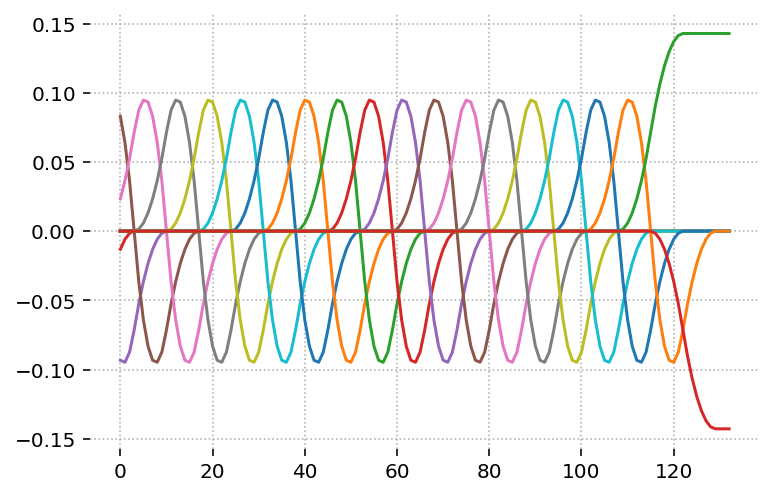

In [229]:
for i in range(B0.shape[-1]):
    plt.plot(B0[1,:-5,i])

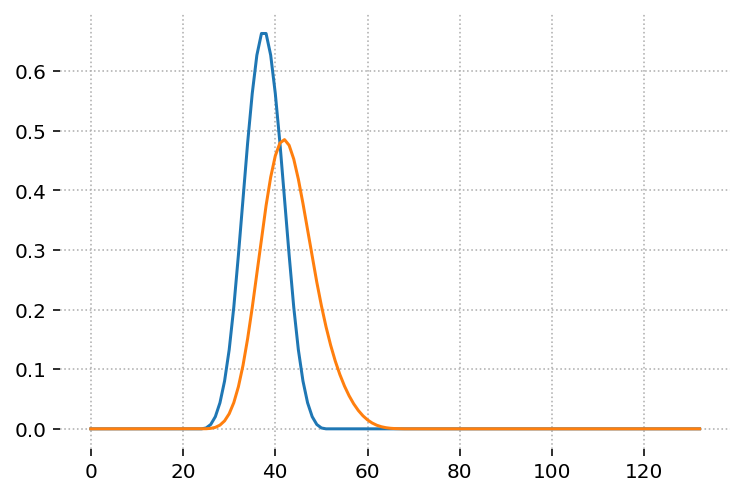

In [235]:
plt.plot(B0[1,:-5,10].cumsum())
plt.plot(B0[0,:-5,10])


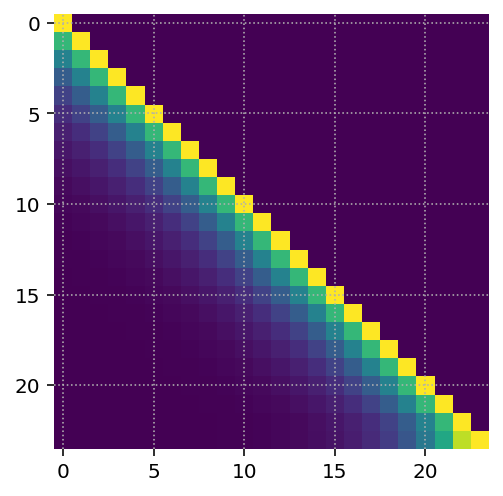

In [236]:
arma2 = np.eye(B0.shape[-1]) ## Prior covariance matrix for the splines to avoid too many wrinkles
for j in range(arma2.shape[0]-1):
    arma2[j+1,j] = -0.667
arma2[-1,-2] = -.9
arma2 = np.linalg.inv(arma2)
plt.imshow(arma2)

### Case and genome data
Prepare as arrays and add Germany as a whole

In [109]:
seq_index = np.array([list(cases_land.columns).index(i) for i in genomes.index.levels[1]])

In [110]:
import importlib
importlib.reload(gs.misc.misc)
importlib.reload(gs.misc)
from genomicsurveillance.misc import MultiLineageTimeShift, plot_lad, plot_growth_rates

In [111]:
from numpyro.infer import Trace_ELBO

In [112]:
GG = np.concatenate([G, G.sum(0, keepdims=True)], axis=0) # Add Germany as a whole
CC = np.concatenate([C, C.sum(0, keepdims=True)], axis=0)    

In [113]:
CC[2,cases_land.columns == np.datetime64("2022-03-08")] = np.nan # int women's day in Berlin..

### Model
Multi-lineage model with variable growth rates (random effect) across states

In [237]:
model = MultiLineageTimeShift(
    CC,
    GG,    
    seq_index,
    np.concatenate([capita.values, capita.values.sum().reshape(1)]),
    #auto_correlation=0.5,
    #linearize=True,
    arma = arma2,
    b_scale=0.01,
    b0_scale=0.3,
    c_scale=20,
    beta_scale= np.append(10.,np.repeat(10., B0.shape[2]-1)),# np.concatenate([np.repeat(1., knots.num_long_basis), np.repeat(.1, knots.num_short_basis)]),
    tau=4.6,
    basis=B0, #knots.basis,
    shift=7,  
    alpha0=.01,
    alpha1=100., 
    week=True,
    fit_logits=True,
    #model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=5), 'num_epochs':10000, 'lr':0.001, 'num_samples': 100}
    model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=10), 'num_epochs':10000, 'lr':0.005, 'lrd': 0.1 ** (1/10000), 'num_samples': 100}

)

In [238]:
model.fit()

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:6576: UserWarning: Explicitly requested dtype float requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


SVI step 0 / 10,000 | 0 %
SVI step 1,000 / 10,000 | 10 %
SVI step 2,000 / 10,000 | 20 %
SVI step 3,000 / 10,000 | 30 %
SVI step 4,000 / 10,000 | 40 %
SVI step 5,000 / 10,000 | 50 %
SVI step 6,000 / 10,000 | 60 %
SVI step 7,000 / 10,000 | 70 %
SVI step 8,000 / 10,000 | 80 %
SVI step 9,000 / 10,000 | 90 %


Text(0, 0.5, 'ELBO')

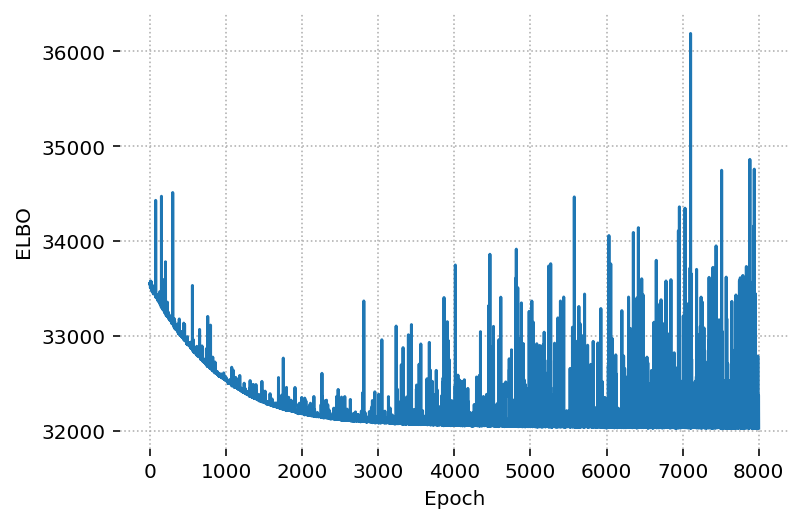

In [239]:
plt.plot(model.loss[2000:])
plt.xlabel('Epoch')
plt.ylabel('ELBO')
#plt.ylim((None, model.loss[2000]))

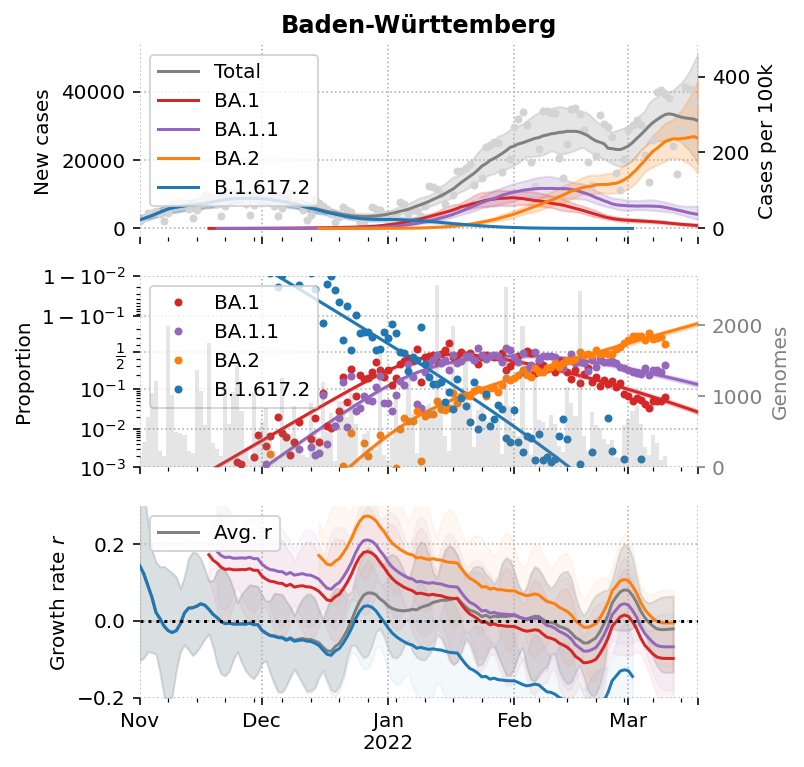

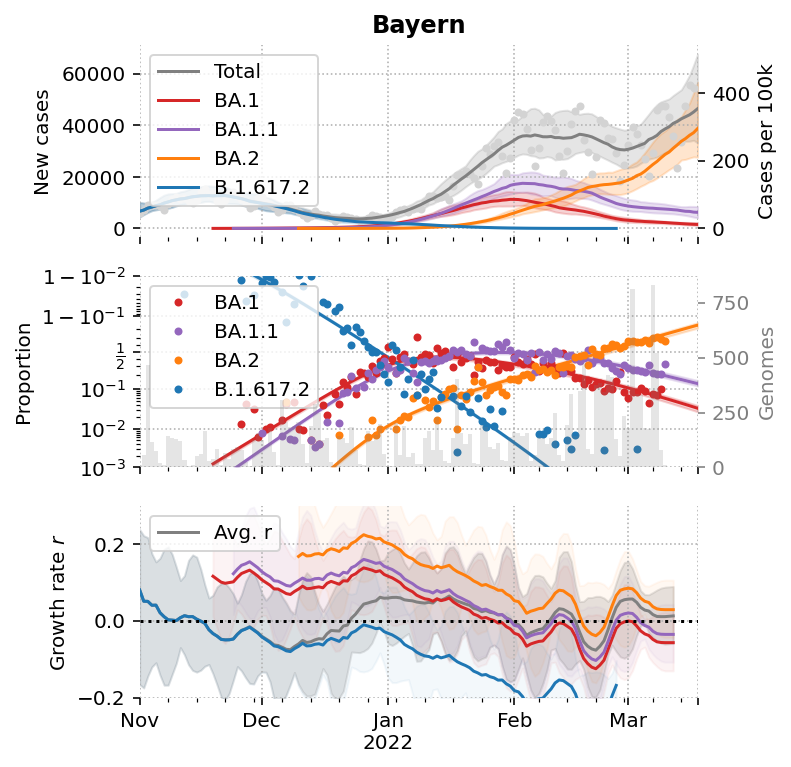

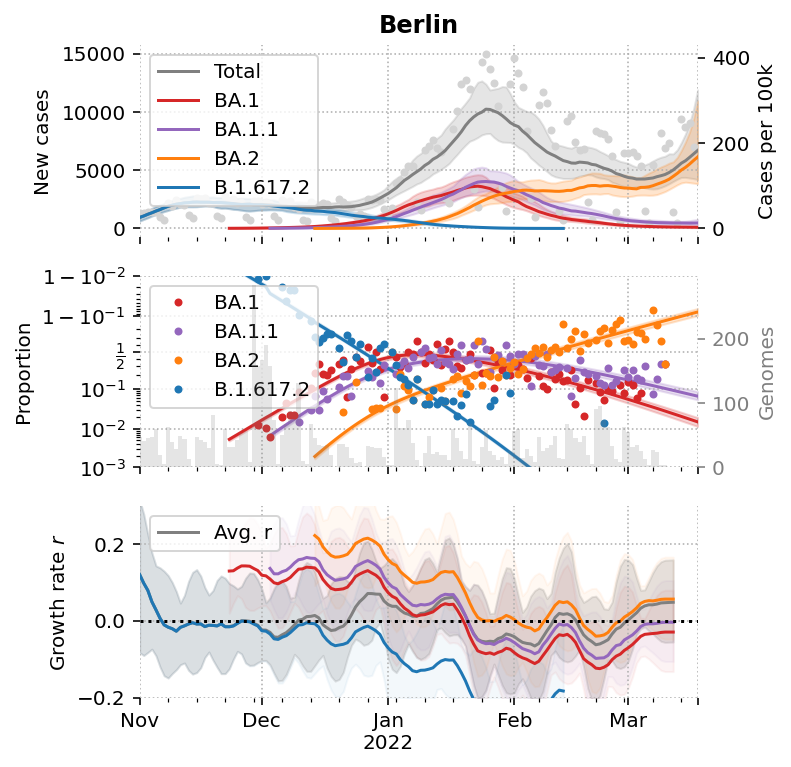

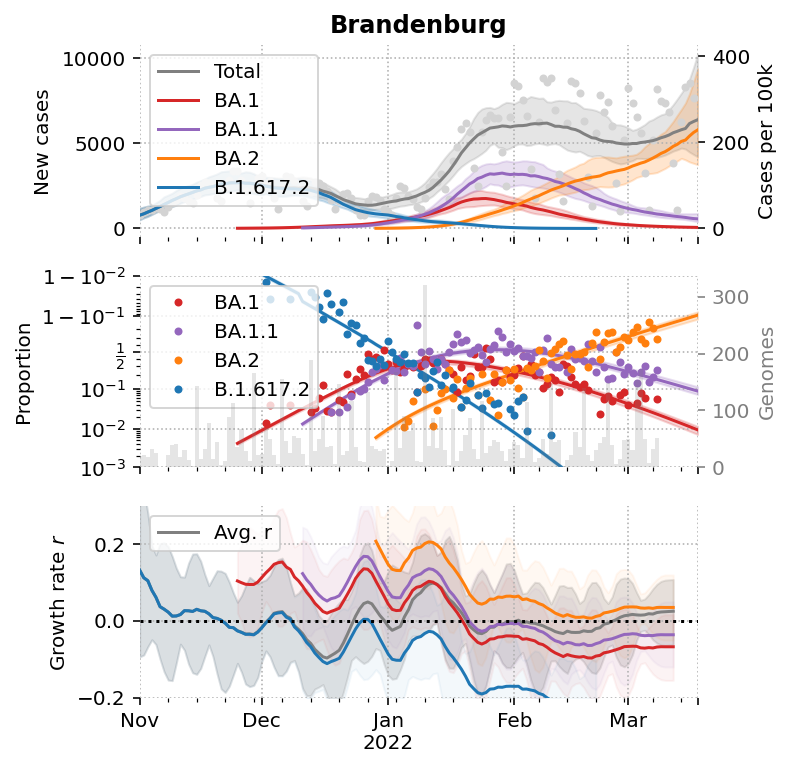

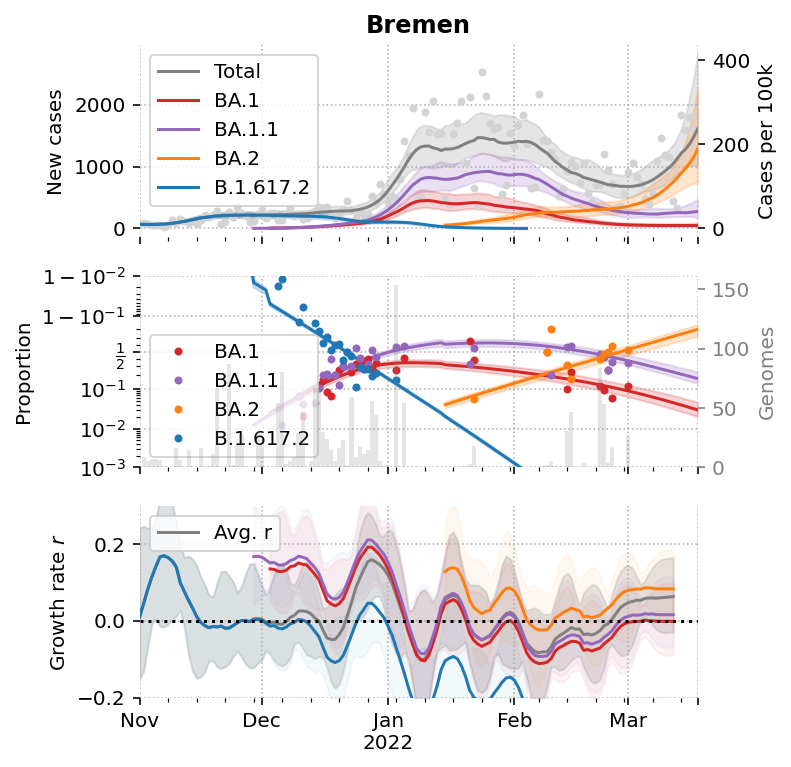

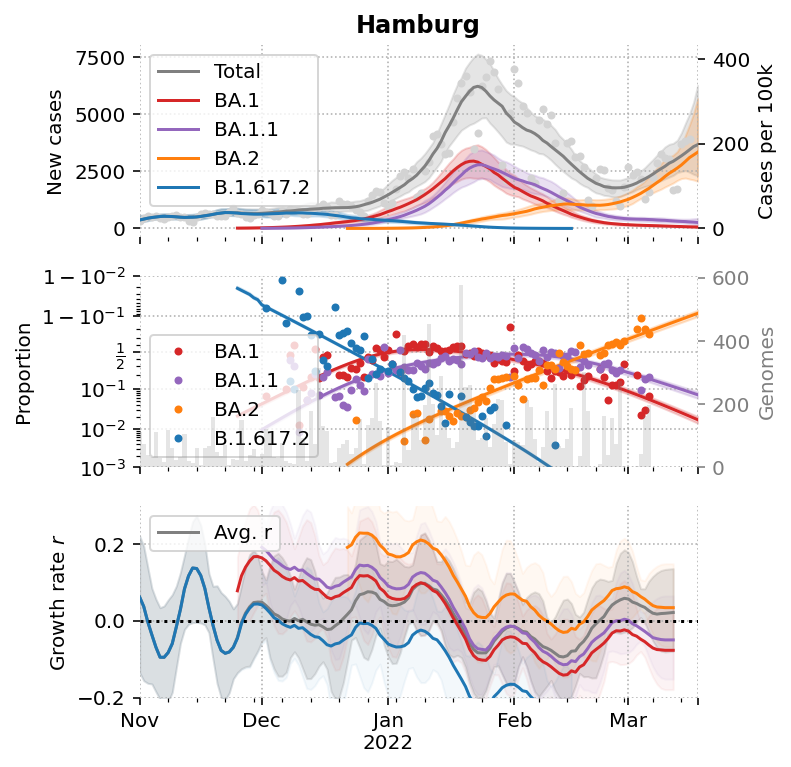

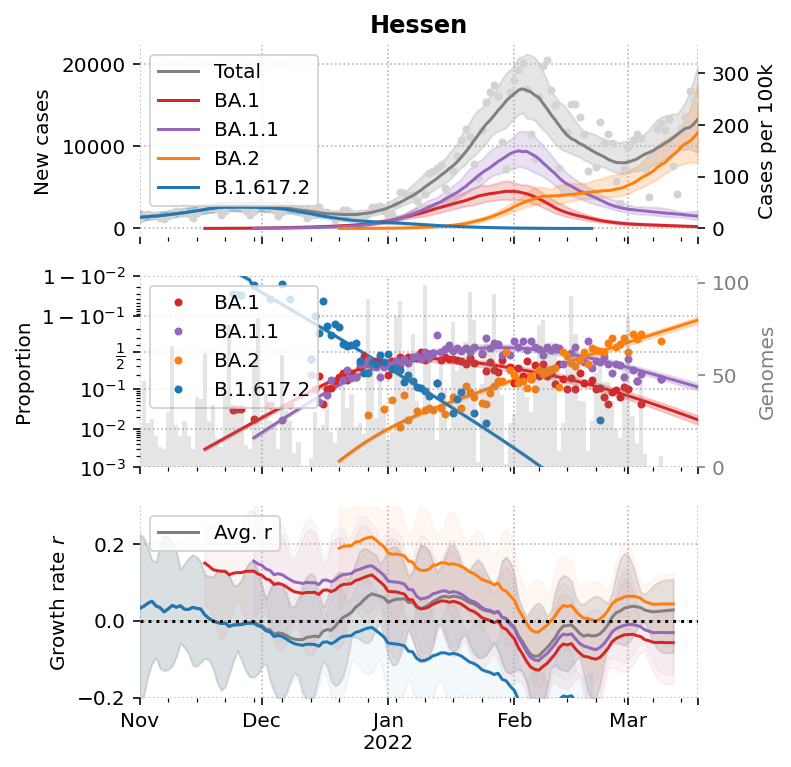

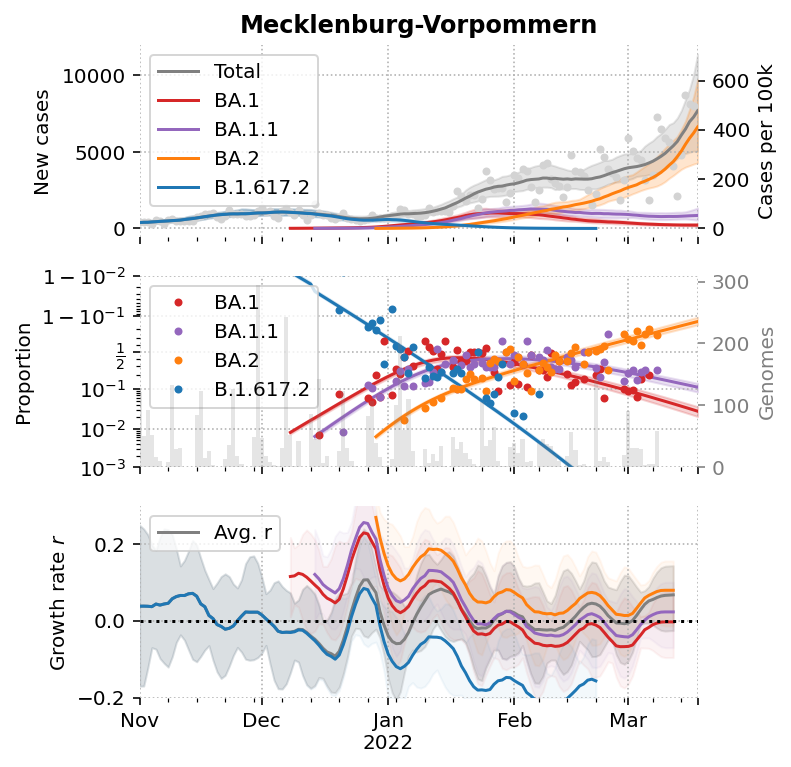

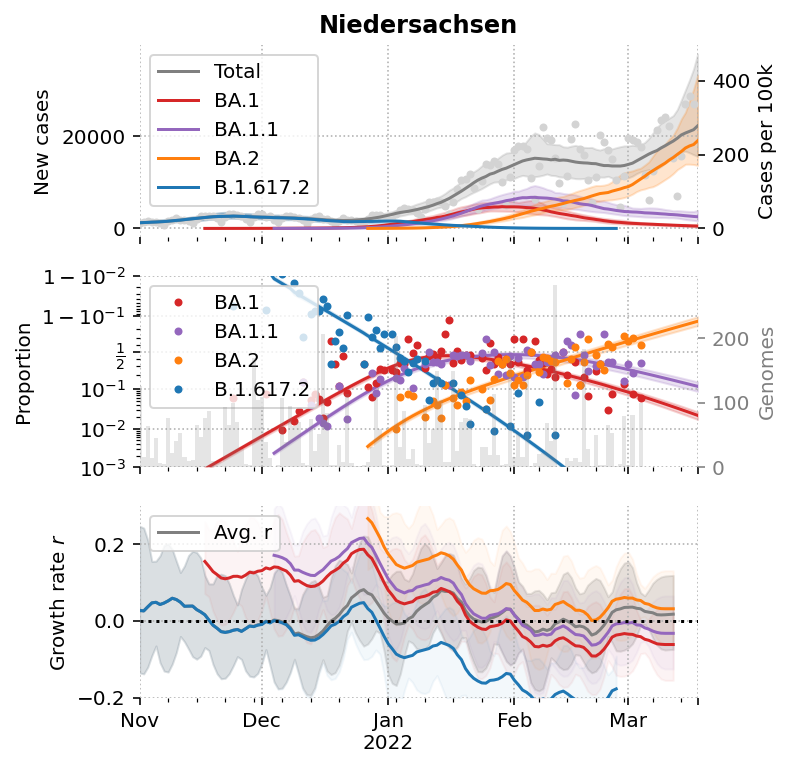

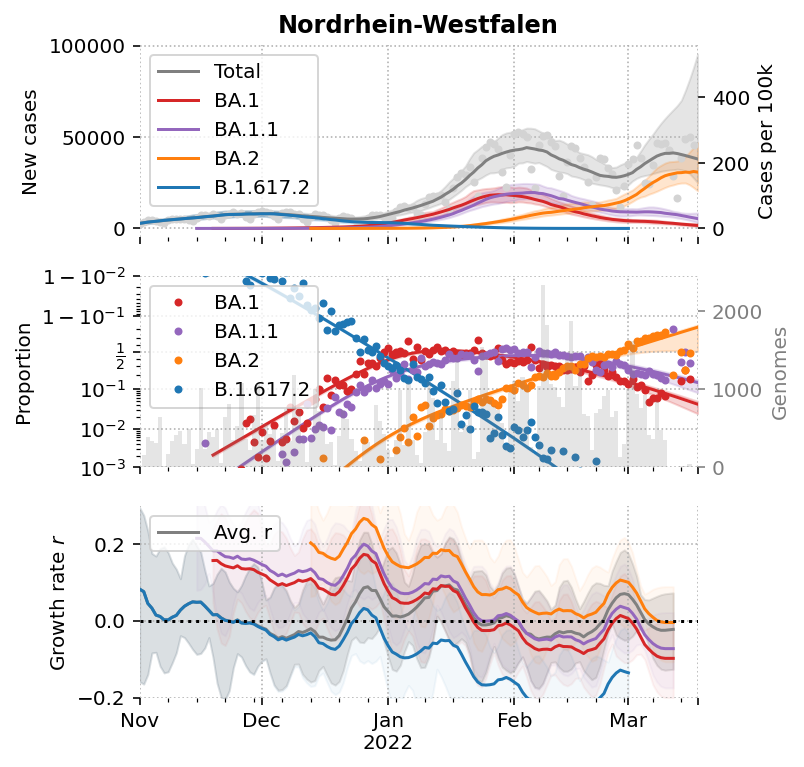

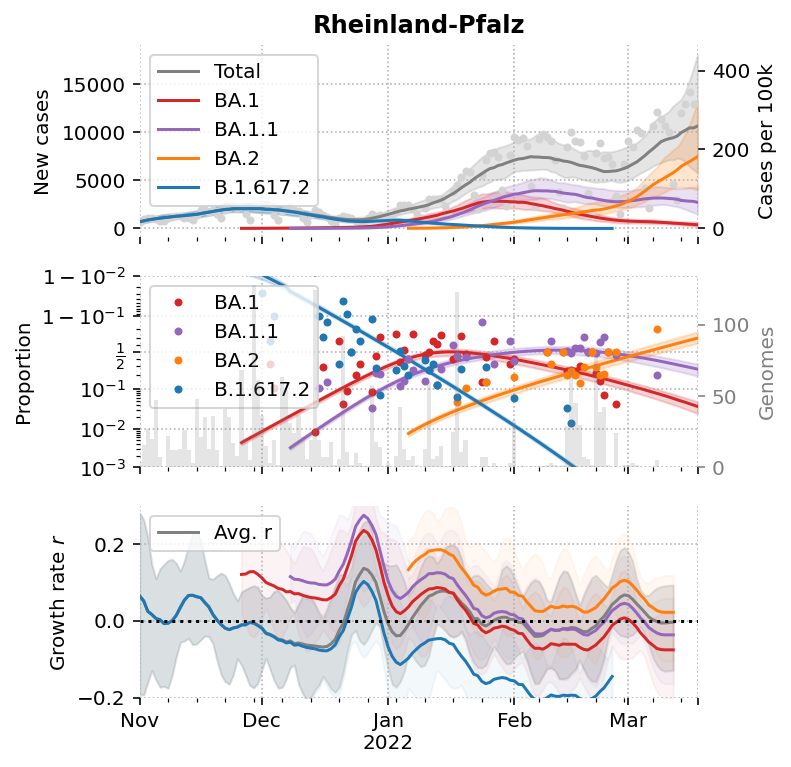

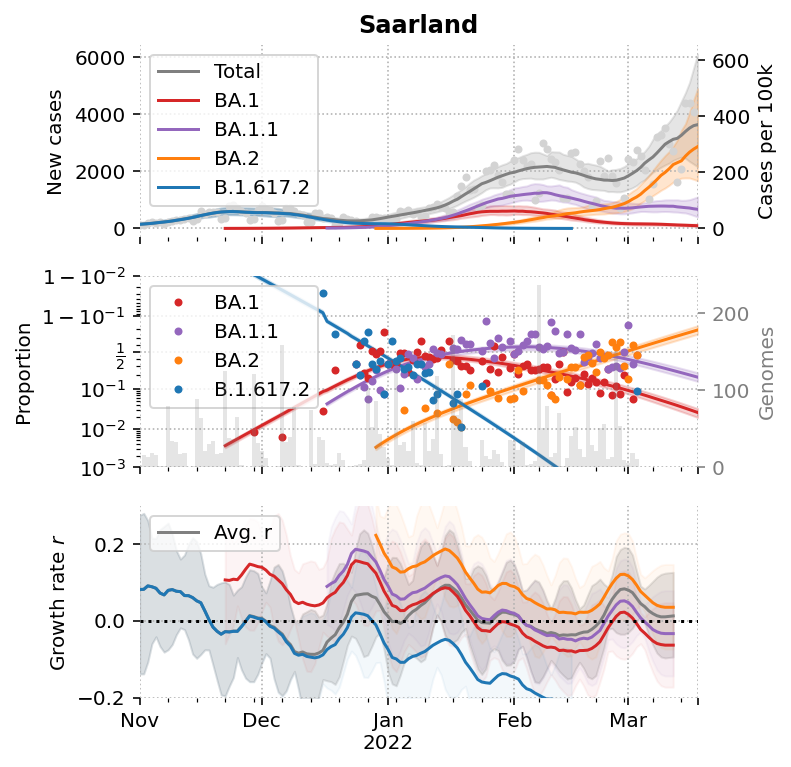

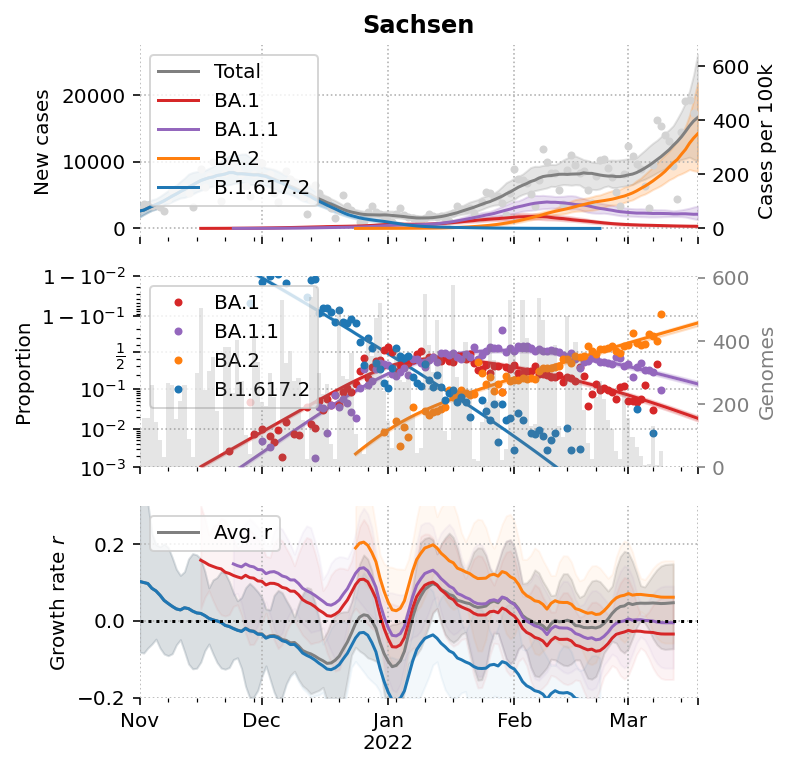

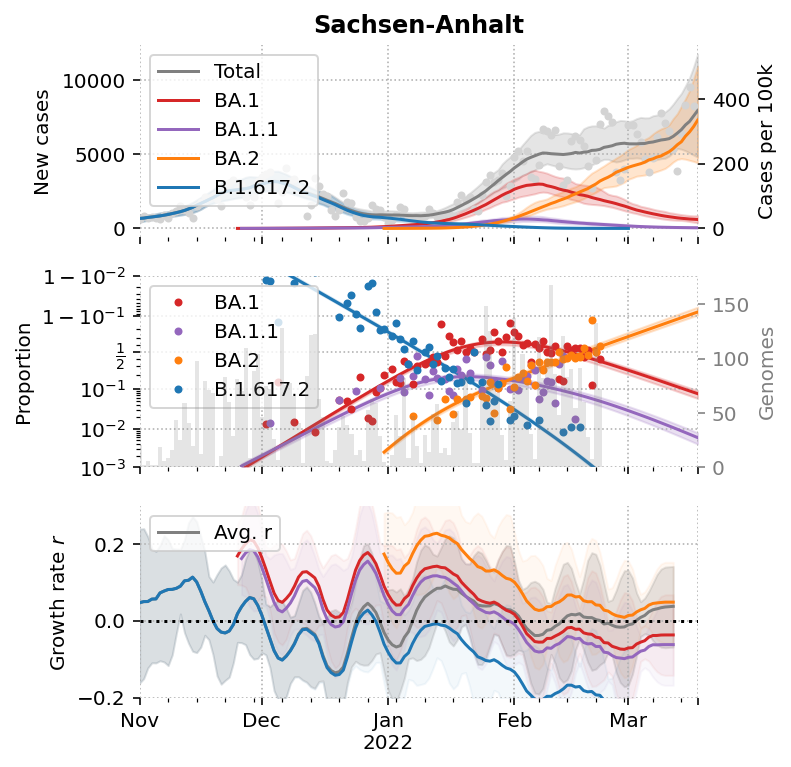

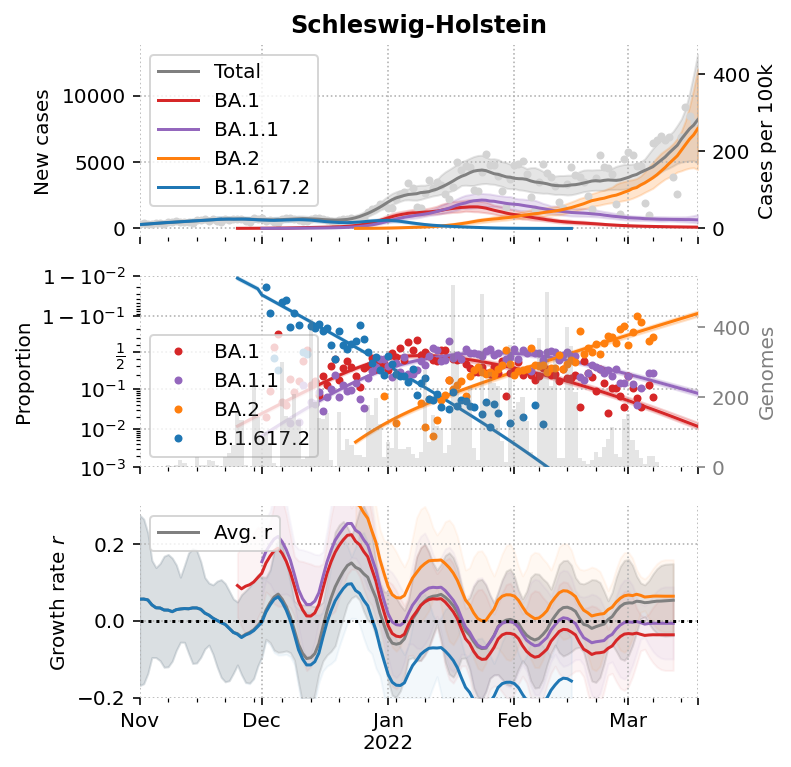

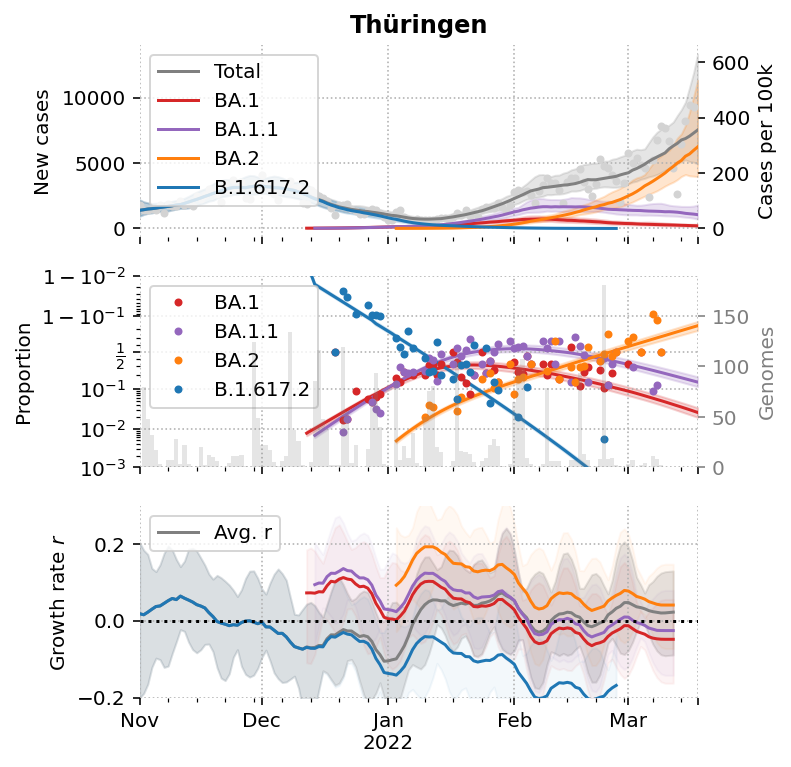

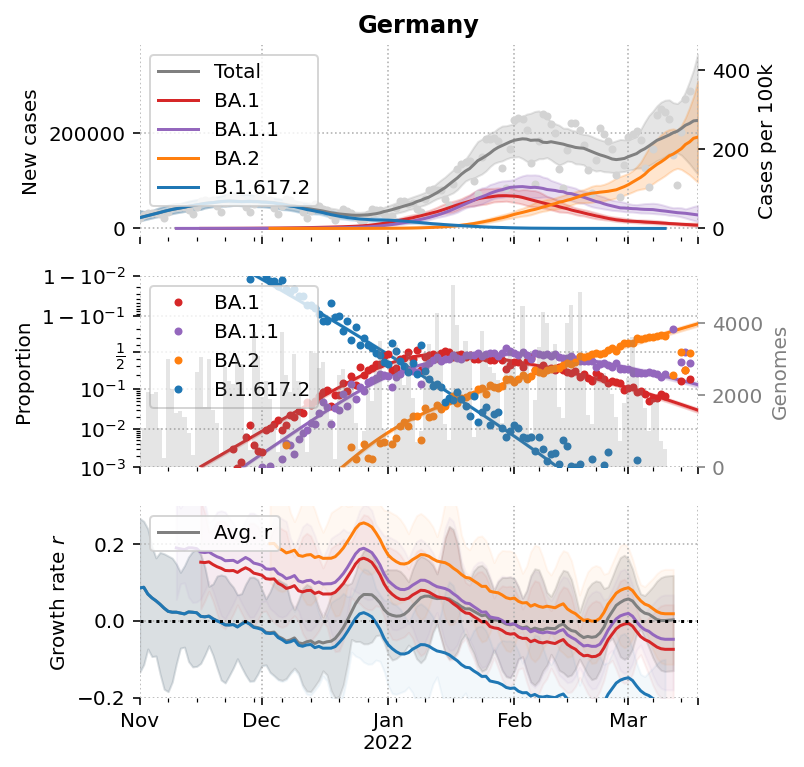

In [240]:
#from genomicsurveillance.plots.england import plot_lad, 
from genomicsurveillance.plots.england import plot_median_and_ci
for i,r in enumerate(cases_land.index.to_list() + ["Germany"]):
    w = np.where(GG[i].sum(0) >= 1)[0]
    w = list(set(w) - set([3,4]))
    plot_lad(model, i, CC, GG, seq_index, start_date="2021-11-01", show_start_date="2021-11-01",
        lin = w,
        labels = genomes.columns[w],
        lin_colors=np.array(['C3',"C4","C1", "C6","C5" ,"C0", "C9","C0"])[w],#, "C6", "C1","C8"],
        #labels=[alias(y) if alias(y) != "AY.121" else "Orf3a:202L" for y in x],#["B.1.1.7", 'Delta', "AY.4", 'B.1.617.2.5', "B.1.177"],
        case_color="grey",
        case_markercolor="lightgrey",
            figsize=(5,6),
            prop_err=False,
            show_Rt=False)

    ax=plt.gcf().get_axes()
    
    ax[0].set_title(r, size=12, weight='bold')
    #ax[0].set_yscale('log')
    #ax[0].set_ylim((1,None))
   
    #ax[1].grid(which='both', ls=":")
    #ax[0].legend(loc='center left')
    #ax[2].set_ylim((-0.2,0.3))
    #ax[3].grid(False)
    
    #for a in ax:
        #a.xaxis.set_major_formatter(pd.plotting._matplotlib.converter.TimeSeries_DateFormatter("D"))
        #for s in a.spines:
        #    a.spines[s].set_visible(True)
    #fig = plt.gcf()
    #plt.tight_layout()
    ax[1].set_yscale("logit")
    ax[1].set_ylim((1e-3,1-1e-2))
    ax[2].set_ylim((-.2,.3))
    ax[2].legend(loc="upper left")
    ax[2].axhline(0, color='k', ls=":")

In [118]:
w=np.append(model.params['day_mu'][2], 0)
np.exp(w-np.log(np.sum(np.exp(w ), keepdims=True))).sum()

1.0

In [119]:
model.posterior.keys()

dict_keys(['b1', 'b_scale_lin', 'bc0', 'beta1', 'c1', 't', 'b0'])

Text(0.5, 1.0, 'Germany')

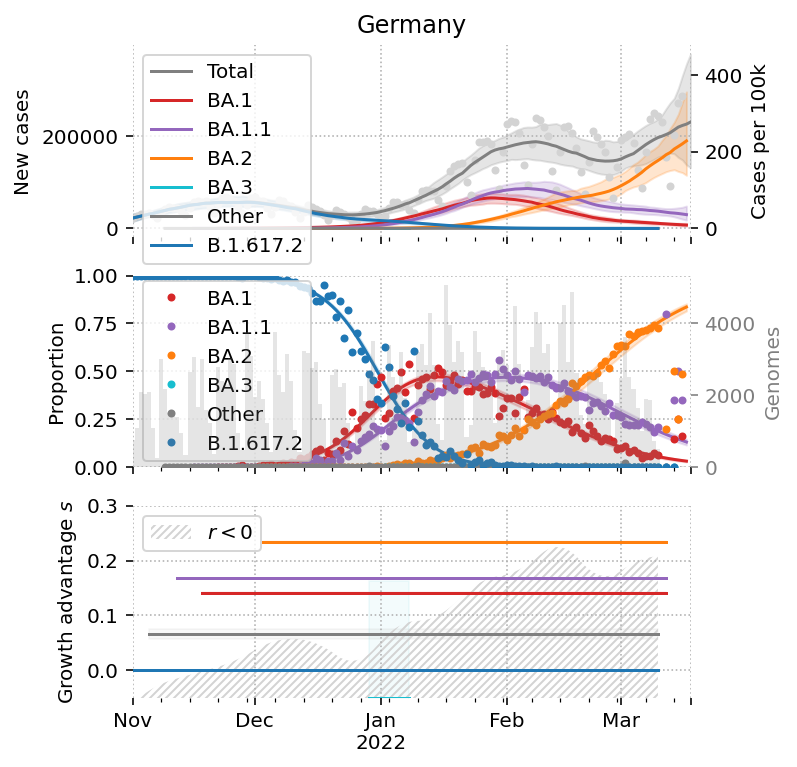

In [120]:
w = np.arange(genomes.shape[-1])
plot_lad(model, -1, 
             #model_uk.cases, model_uk.lineages, np.array([cases_uk.index.to_list().index(i) for i in genomes_uk.index]), 
             start_date="2021-11-01", 
             show_start_date="2021-11-01",
            lin = w,
            labels = genomes.columns[w],
            lin_colors=np.array(['C3','C4', "C1" ,"C9", "C7","C0"])[w],#, "C6", "C1","C8"],
            #labels=[alias(y) if alias(y) != "AY.121" else "Orf3a:202L" for y in x],#["B.1.1.7", 'Delta', "AY.4", 'B.1.617.2.5', "B.1.177"],
            case_color="grey",
            case_markercolor="lightgrey",
                figsize=(5,6),
                prop_err=False,
            clip_to_lineage_data = True,
            bleed_left = 1,
             bleed_right=6,
             show_Rt = False,
             plot_s= True
            )
plt.gcf().get_axes()[2].set_ylim(-0.05,0.3)
plt.gcf().get_axes()[0].set_title("Germany")

In [121]:
λ = model.get_lambda_lineage().mean(0) / model.population[:,np.newaxis, np.newaxis]

In [122]:
λ.shape

(17, 138, 6)

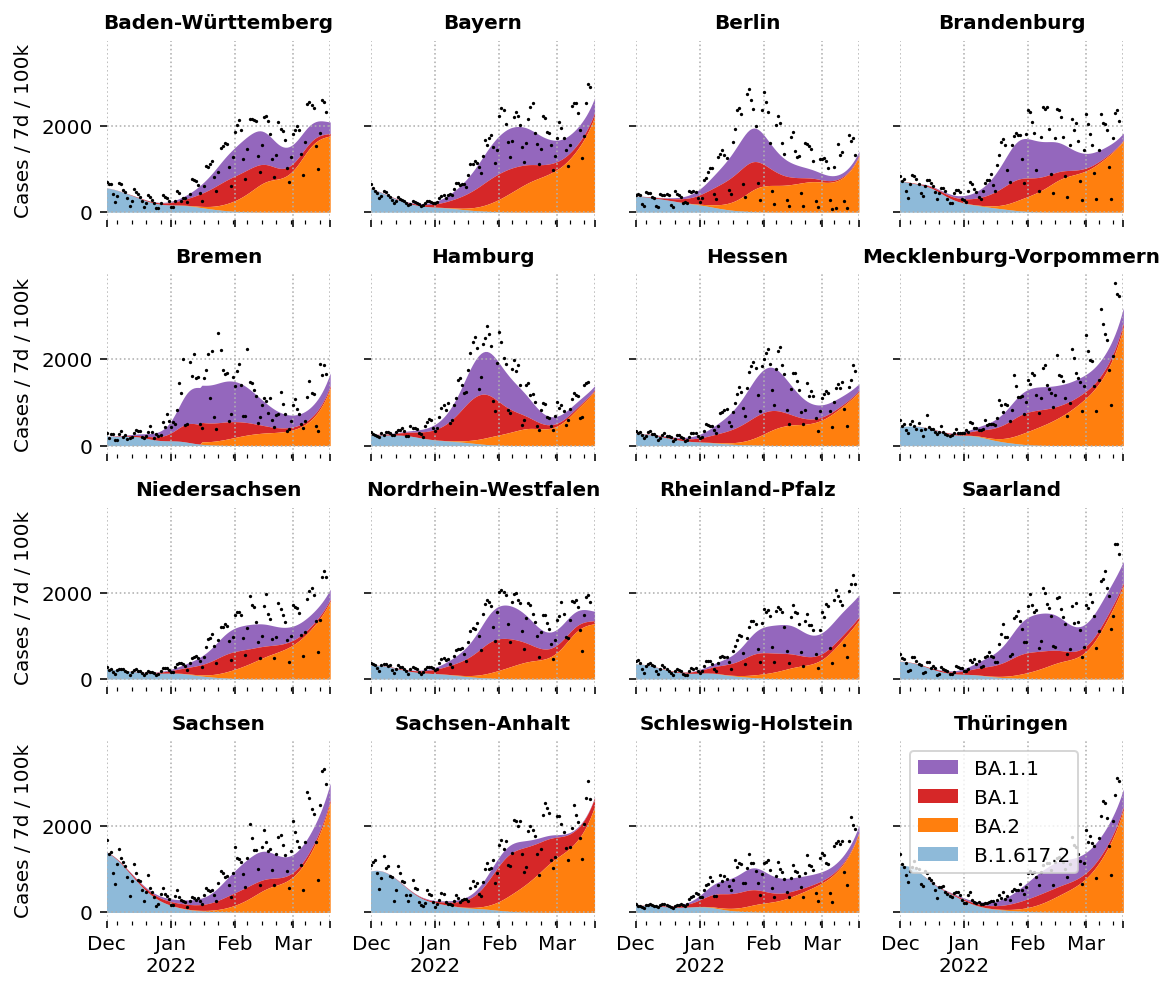

In [250]:
fig, ax = plt.subplots(4,4, figsize=(8,7), sharex=True, sharey=True)
ax = ax.flatten()
for i,r in enumerate(cases_land.index):
    y = pd.DataFrame(λ[i,:,:], columns=genomes.columns, index=cases_land.columns[1] + np.arange(λ.shape[1]).astype('timedelta64[D]')) #cases_land.loc[r].loc["2021-12-01":,'AnzahlFall'] / capita[r] * 1000 #* 700
    y = y[["B.1.617.2","BA.2","BA.1","BA.1.1","BA.3"]].cumsum(1) * 1000 * 700
    #y.index.name = 'date'
    #x = prop_bl.loc[r,:,:][0].unstack()
    #z = x[0.5] * y
    y["BA.1"].plot(ax=ax[i], ls="", label="")
    (cases_land.loc[r]/capita[r]*1000 * 700).plot(ax=ax[i], marker=".", markersize=1.3, color="k", ls="", label="")
    ax[i].fill_between(y.index, y["BA.1"], y["BA.1.1"], color='C4', alpha=1, lw=0, label="BA.1.1")
    ax[i].fill_between(y.index, y["BA.2"], y["BA.1"], color='C3', alpha=1, lw=0, label="BA.1")
    ax[i].fill_between(y.index, y["B.1.617.2"], y["BA.2"], color='C1', alpha=1, lw=0, label="BA.2")
    ax[i].fill_between(y.index, y["B.1.617.2"], color='C0', alpha=.5, lw=0, label="B.1.617.2")
    #ax[i].fill_between(z.index, y-x[0.95]*y, y-x[0.5]*y, color='none',alpha=1, lw=0, label="Omicron", hatch="//////", edgecolor="C3")
    ax[i].set_title(r, size=10 , weight='bold')
    ax[i].set_xlabel(None)
    ax[i].set_ylabel("Cases / 7d / 100k")
    ax[i].grid(ls=":")
    ax[i].set_xlim(("2021-12-01",None))
    for a in ax[i].spines.values():
        a.set_visible(False)
ax[-1].legend(title=None)
plt.tight_layout()
#fig.savefig("plots/omi_abs_by_area.png",dpi=200,bbox_inches='tight',pad_inches=0.2)

In [124]:
λ[-1,-1] / λ[-1,-1].sum()

array([2.98749554e-02, 1.24270025e-01, 8.45839165e-01, 1.32008441e-05,
       1.75149812e-06, 9.02471538e-07])

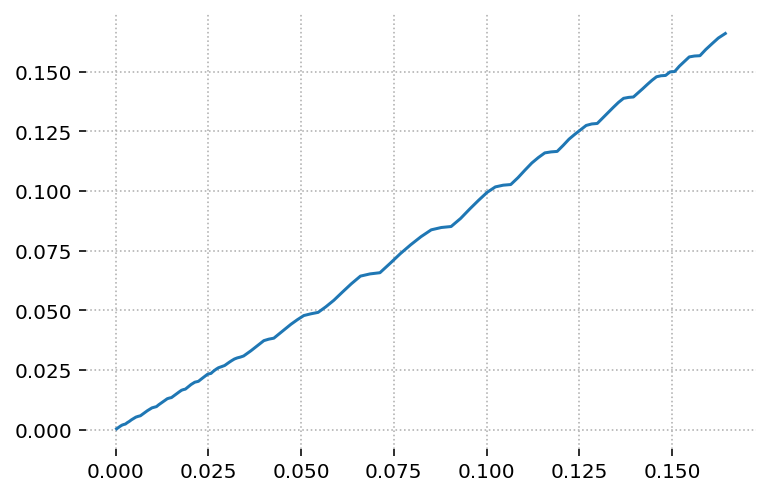

In [125]:
plt.plot(λ[2].sum(1).cumsum()[:-1], cases_land.loc['Berlin'].cumsum() / capita[2])

In [126]:
from genomicsurveillance.misc import get_transmissibility

In [127]:
pd.DataFrame(get_transmissibility(model), columns=genomes.columns, index=cases_land.index.to_list() + ["Germany"])

lineage                     BA.1    BA.1.1      BA.2      BA.3     Other  \
Baden-Württemberg       0.141655  0.172048  0.234678 -0.063219  0.015915   
Bayern                  0.148959  0.170328  0.234555 -0.041630  0.061980   
Berlin                  0.144664  0.170547  0.230105 -0.041630  0.022898   
Brandenburg             0.130471  0.163086  0.234241 -0.061675  0.041039   
Bremen                  0.147399  0.165390  0.232821 -0.041630  0.061821   
Hamburg                 0.123390  0.151037  0.234777 -0.060534  0.060916   
Hessen                  0.135383  0.161322  0.234710 -0.061369  0.019836   
Mecklenburg-Vorpommern  0.145723  0.171968  0.228101 -0.041630  0.041039   
Niedersachsen           0.140195  0.169427  0.233905 -0.041630  0.042487   
Nordrhein-Westfalen     0.141813  0.166865  0.234863 -0.064084  0.045120   
Rheinland-Pfalz         0.132962  0.171677  0.231002 -0.041630  0.018649   
Saarland                0.135081  0.165402  0.234769 -0.041630  0.016651   
Sachsen                 0.138783  0.168491  0.234808 -0.062372  0.066230   
Sachsen-Anhalt          0.150335  0.125676  0.234736 -0.058429  0.041039   
Schleswig-Holstein      0.127417  0.157347  0.227507 -0.062713  0.018428   
Thüringen               0.143306  0.165993  0.234511 -0.041630  0.023198   
Germany                 0.141523  0.167528  0.234381 -0.048237  0.065858   

lineage                 B.1.617.2  
Baden-Württemberg             0.0  
Bayern                        0.0  
Berlin                        0.0  
Brandenburg                   0.0  
Bremen                        0.0  
Hamburg                       0.0  
Hessen                        0.0  
Mecklenburg-Vorpommern        0.0  
Niedersachsen                 0.0  
Nordrhein-Westfalen           0.0  
Rheinland-Pfalz               0.0  
Saarland                      0.0  
Sachsen                       0.0  
Sachsen-Anhalt                0.0  
Schleswig-Holstein            0.0  
Thüringen                     0.0  
Germany                       0.0

n  Growth rate r to ancestor      +/-   \
Lineage                                                  
BA.1       117374                   0.068513  0.007410   
BA.1.1     137440                   0.083222  0.010952   
BA.2        85264                   0.144958  0.002442   
BA.3           72                  -0.041630  0.027033   
Other         618                   0.041039  0.020723   
B.1.617.2  237802                   0.000000  0.000000   

           Growth rate r to baseline BA.1       +/-  
Lineage                                              
BA.1                             0.000000  0.007410  
BA.1.1                           0.024416  0.010952  
BA.2                             0.093848  0.002442  
BA.3                            -0.199649  0.027033  
Other                           -0.100786  0.020723  
B.1.617.2                       -0.139356  0.000000

/Users/mg14/Downloads/desh-data/genomicsurveillance/misc/misc.py:917: RuntimeWarning: divide by zero encountered in log
  ax3 = plt.gca().secondary_yaxis('right', functions=(lambda x: np.exp(x*model.tau), lambda x: np.log(x)/model.tau))


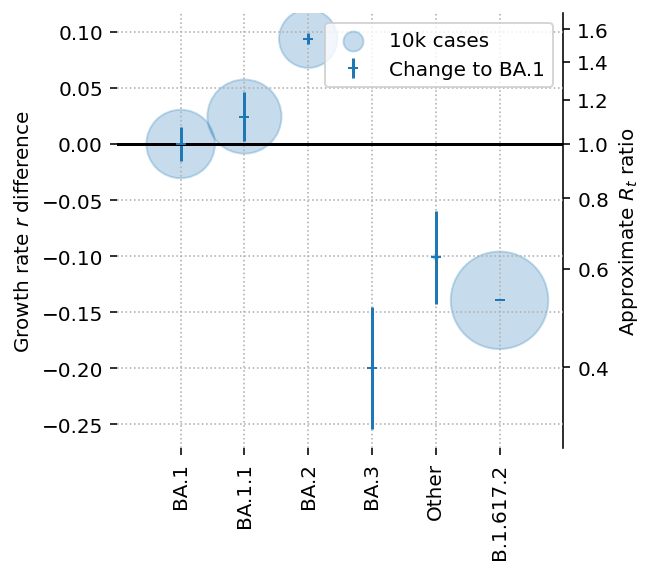

In [128]:
plt.figure(figsize=(4,4))
plot_growth_rates(model, genomes.columns.to_list(), color=["C0","None"], baseline="BA.1")

In [129]:
import geopandas as gpd

In [130]:
bl = gpd.read_file("data/bundeslaender.geojson").set_index("bundesland")

In [131]:
bl

land  \
bundesland                            
Baden-Württemberg       Deutschland   
Bayern                  Deutschland   
Berlin                  Deutschland   
Brandenburg             Deutschland   
Bremen                  Deutschland   
Hamburg                 Deutschland   
Hessen                  Deutschland   
Mecklenburg-Vorpommern  Deutschland   
Niedersachsen           Deutschland   
Nordrhein-Westfalen     Deutschland   
Rheinland-Pfalz         Deutschland   
Saarland                Deutschland   
Sachsen                 Deutschland   
Sachsen-Anhalt          Deutschland   
Schleswig-Holstein      Deutschland   
Thüringen               Deutschland   

                                                                 geometry  
bundesland                                                                 
Baden-Württemberg       MULTIPOLYGON (((7.63396 47.56122, 7.68592 47.5...  
Bayern                  MULTIPOLYGON (((9.63623 47.60202, 9.74582 47.6...  
Berlin                  POLYGON ((13.73143 52.41981, 13.73412 52.40198...  
Brandenburg             POLYGON ((14.03274 51.47500, 14.06259 51.44542...  
Bremen                  MULTIPOLYGON (((8.96595 53.05772, 8.98022 53.0...  
Hamburg                 MULTIPOLYGON (((10.21828 53.49923, 10.26573 53...  
Hessen                  MULTIPOLYGON (((8.90009 49.48187, 8.89974 49.5...  
Mecklenburg-Vorpommern  MULTIPOLYGON (((11.52874 54.07105, 11.51283 54...  
Niedersachsen           MULTIPOLYGON (((10.36397 51.55606, 10.36689 51...  
Nordrhein-Westfalen     MULTIPOLYGON (((6.16603 50.66186, 6.19337 50.6...  
Rheinland-Pfalz         POLYGON ((8.28766 48.99838, 8.23545 48.96749, ...  
Saarland                POLYGON ((7.31027 49.12958, 7.29356 49.11499, ...  
Sachsen                 POLYGON ((12.23908 50.24698, 12.26616 50.25888...  
Sachsen-Anhalt          POLYGON ((12.19559 51.14146, 12.24134 51.13061...  
Schleswig-Holstein      MULTIPOLYGON (((11.00454 54.45007, 11.01815 54...  
Thüringen               POLYGON ((10.59094 50.27180, 10.60497 50.29310...

In [132]:
λ.sum(0)[-1] / λ.sum((0,2))[-1]

array([2.63902746e-02, 1.13134251e-01, 7.85702189e-01, 7.47647251e-02,
       7.25246114e-06, 1.30777604e-06])

In [133]:
de = bl.copy()
de.geometry = de.buffer(1e-2)
de = de.dissolve(by='land')

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


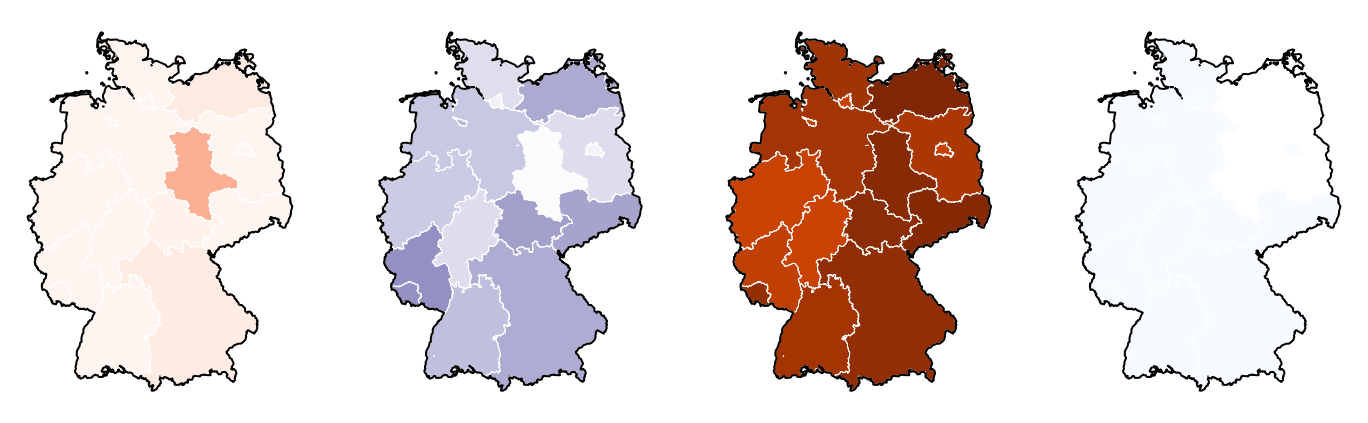

In [134]:
from matplotlib.colors import LogNorm
fig, axs = plt.subplots(1,4, figsize=(12,6))
for ax in axs:
    ax.axis("off")
#camera = Camera(fig)
vmax = λ[:-1,-1,:].max()
vmin = 1e-4
b0 = bl.copy().merge(pd.DataFrame(λ[:-1,-1,:], columns=genomes.columns, index=bl.index), 
                     left_index=True, right_index=True)
b0.plot("BA.1", ax=axs[0], cmap="Reds", norm=LogNorm(vmin=vmin, vmax=vmax))
b0.plot("BA.1.1", ax=axs[1], cmap="Purples", norm=LogNorm(vmin=vmin, vmax=vmax))
b0.plot("BA.2", ax=axs[2], cmap="Oranges",norm=LogNorm(vmin=vmin, vmax=vmax))
b0.plot("Other", ax=axs[3], cmap="Blues",norm=LogNorm(vmin=vmin, vmax=vmax))
for ax in axs:
    bl.boundary.plot(color='w',lw=0.5, ax=ax)
    de.boundary.plot(color='k',lw=1, ax=ax)

In [135]:
b0.iloc[:,2:] * capita.values.reshape(-1,1)

BA.1       BA.1.1          BA.2          BA.3  \
bundesland                                                                     
Baden-Württemberg        891.682736  4196.784462  28086.029940      0.001544   
Bayern                  1650.534827  6535.255425  41543.341892      0.000000   
Berlin                   112.150304   500.424515   6779.034459      0.000000   
Brandenburg               61.808982   589.163907   5991.417415      0.435418   
Bremen                    50.692677   286.949811   1298.269502      0.000000   
Hamburg                   62.795438   263.360507   3341.812583      0.246001   
Hessen                   222.729903  1449.255173  11261.397489      0.199713   
Mecklenburg-Vorpommern   206.285886   815.117444   6329.553384      0.000000   
Niedersachsen            527.333443  2685.114541  20595.730498      0.000000   
Nordrhein-Westfalen     1721.144702  5650.291933  32885.128533  65950.198196   
Rheinland-Pfalz          418.537013  2973.342597   8037.108968      0.000000   
Saarland                  98.666091   705.610151   3029.588957      0.000000   
Sachsen                  326.103174  2261.339673  14790.451740   2203.778217   
Sachsen-Anhalt           623.048678    48.253766   7667.034759      0.192939   
Schleswig-Holstein        99.648805   664.328204   7633.688171      0.165329   
Thüringen                228.394130  1248.248687   7183.965278      0.000000   

                           Other  B.1.617.2  
bundesland                                   
Baden-Württemberg       0.016674   0.046752  
Bayern                  0.066070   0.026853  
Berlin                  0.005871   0.001226  
Brandenburg             0.000000   0.005707  
Bremen                  0.003578   0.000338  
Hamburg                 0.006580   0.002519  
Hessen                  2.161205   0.005691  
Mecklenburg-Vorpommern  0.000000   0.011687  
Niedersachsen           0.017154   0.025103  
Nordrhein-Westfalen     0.010657   0.038547  
Rheinland-Pfalz         0.009385   0.031568  
Saarland                0.009879   0.004111  
Sachsen                 0.017269   0.013697  
Sachsen-Anhalt          0.000000   0.034576  
Schleswig-Holstein      0.005795   0.004730  
Thüringen               0.048648   0.030537

In [251]:
r = model.get_growth_rate_lineage(ltla=None).mean(0)[:,-5,:]
r

array([[-0.10744021, -0.07701203, -0.01452501, -0.3325451 , -0.23174095,
        -0.24912436],
       [-0.05610862, -0.03461142,  0.02942154, -0.20497732, -0.14303794,
        -0.20497732],
       [-0.02636215, -0.00055246,  0.05906075, -0.17110726, -0.14394439,
        -0.17110726],
       [-0.07229607, -0.03976867,  0.03129646, -0.26520263, -0.20279342,
        -0.20279342],
       [ 0.00245639,  0.0197909 ,  0.08782979, -0.14508083, -0.08693731,
        -0.14508083],
       [-0.07292101, -0.04542197,  0.03845888, -0.28107774, -0.1355993 ,
        -0.19635444],
       [-0.06203455, -0.03635951,  0.03723697, -0.27100277, -0.15951389,
        -0.197426  ],
       [-0.00614014,  0.02006457,  0.07640286, -0.15207499, -0.15207499,
        -0.15207499],
       [-0.05783153, -0.02853483,  0.03597741, -0.19786676, -0.15540596,
        -0.19786676],
       [-0.10137876, -0.07634666, -0.00827271, -0.30205072, -0.19924604,
        -0.24315314],
       [-0.07263086, -0.0341524 ,  0.02515913, -0.

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/geopandas/plotting.py:376: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/geopandas/plotting.py:376: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/geopandas/plotting.py:376: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/geopandas/plotting.py:376: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


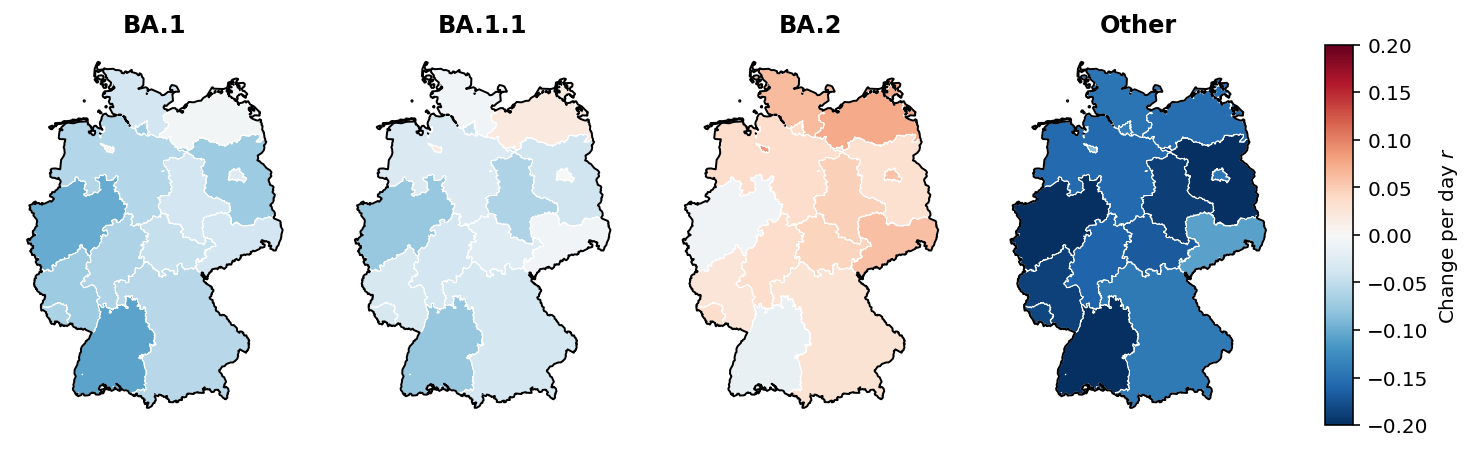

In [252]:
from matplotlib.colors import LogNorm
fig, axs = plt.subplots(1,5, figsize=(12,3.5), gridspec_kw={'width_ratios': [1, 1,1,1,0.1]})
for ax in axs[:-1]:
    ax.axis("off")
#camera = Camera(fig)
vmax = λ[:-1,-1,:].max()
vmin = 1e-4
d = pd.DataFrame(r[:-1,:], columns=genomes.columns, index=bl.index)
#d.loc["Sachsen-Anhalt"]=np.nan
b0 = bl.copy().merge(d, 
                     left_index=True, right_index=True)
b0.plot("BA.1", ax=axs[0], cmap="RdBu_r", vmin=-0.2,vmax=0.2, cax=axs[4], legend_kwds={'label': "Change per day $r$", 'pad':0.3}, legend=True, missing_kwds= dict(color = "lightgrey"))# norm=LogNorm(vmin=vmin, vmax=vmax))
b0.plot("BA.1.1", ax=axs[1], cmap="RdBu_r", vmin=-0.2,vmax=0.2,missing_kwds= dict(color = "lightgrey"))#, norm=LogNorm(vmin=vmin, vmax=vmax))
b0.plot("BA.2", ax=axs[2], cmap="RdBu_r", vmin=-0.2,vmax=0.2,missing_kwds= dict(color = "lightgrey"))#,norm=LogNorm(vmin=vmin, vmax=vmax))
b0.plot("Other", ax=axs[3], cmap="RdBu_r", vmin=-0.2,vmax=0.2,missing_kwds= dict(color = "lightgrey"))#,norm=LogNorm(vmin=vmin, vmax=vmax))
for i,ax in enumerate(axs[:-1]):
    ax.set_title(genomes.columns[[0,1,2,4]][i], weight='bold')
    bl.boundary.plot(color='w',lw=0.5, ax=ax)
    de.boundary.plot(color='k',lw=1, ax=ax)

In [138]:
from sklearn.linear_model import LinearRegression as LR
from adjustText import adjust_text
import re

In [139]:
j

15

0.07940841752401825
0.07532682870090493
0.08194568583702094


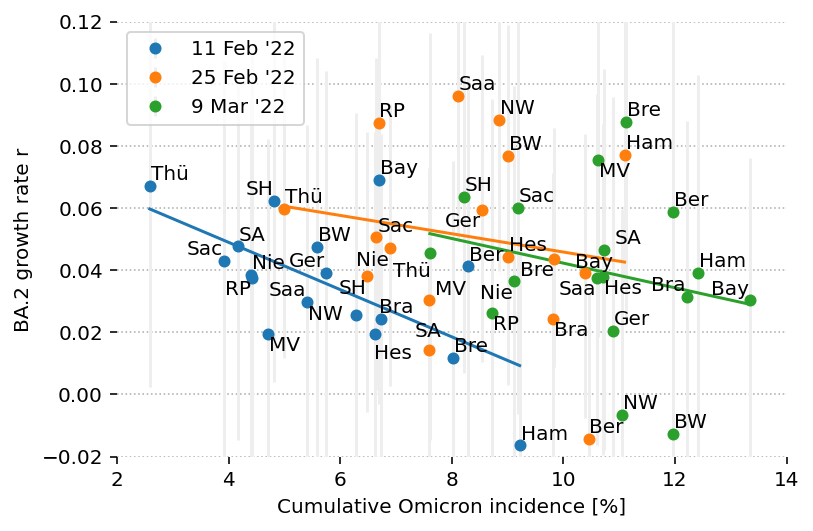

In [253]:
fig, axs = plt.subplots(1,1, figsize=(6,4), sharey=True)
#axs = axs.flatten()
text=[]
for k,l in enumerate(["2022-02-11", "2022-02-25","2022-03-09"]):
    j = np.where(cases_land.columns == l)[0][0]
    ax = axs#[0]
    ci = np.quantile(model.get_growth_rate_lineage(ltla=None)[:,:,j,2], (0.1, 0.9), axis=0)
    r = model.get_growth_rate_lineage(ltla=None).mean(0)[:,j,:]

    lr = LR()
    x = λ[...,:j,:3].sum((1,2)) * 100
    y = r[:,2]
    lr.fit(x[:,np.newaxis], y)
    ax.errorbar(x, y, yerr=np.abs(ci - y[np.newaxis,:]), ls="", marker=".", ms=10,color=f'C{k}', ecolor='#EEEEEE', 
               label=cases_land.columns[j].strftime("%-d %b \'%y"))
    #ax.set_title(cases_land.columns[j].strftime("%-d %b \'%y"))

    l=[re.sub("[a-zöüä\-]","",x) if re.search("-",x) else x[:3] for x in (cases_land.index.to_list() + ['Germany'])]
    
    for i in range(x.shape[0]):
        if 1:#l[i]#in ["BW","NW","RP","Saa"]:
            text.append(ax.text(x[i], y[i], l[i], color='k', va='bottom', ha='center'))
    x.sort()
    y = lr.predict(x[:,np.newaxis])
    line = ax.plot(x, y, ls="-", c=f'C{k}')
    #plt.axline((0, lr.intercept_), slope=lr.coef_)
    #plt.scatter(λ[...,:2].sum((1,2)), r[:,2])
    ax.set_xlabel("Cumulative Omicron incidence [%]")
    if k == 0: 
        ax.set_ylabel("BA.2 growth rate r") 
    ax.set_ylim((-0.02,0.12))
    ax.set_xlim((2,14))
    print(lr.intercept_)

adjust_text(text,) 
                #add_objects=line, 
                #expand_objects = (1,1),
                #force_objects =  (0, 0.2),
                #only_move=dict(objects='y', text='y', points='y'),
                #arrowprops=dict(arrowstyle="-", color='grey', lw=0.5), )
ax.grid(axis='x', which='major')
ax.legend(loc='upper left')


In [141]:
λ[-1,-1,2]/ λ[-1,-1,:].sum()

0.8458391650775937

In [142]:
d = pd.DataFrame(model.get_growth_rate_lineage(ltla=None).mean(0)[:,[-24,-10],2], index=cases_land.index.to_list() + ["Germany"], columns=cases_land.columns[[-24,-10]])

<AxesSubplot:>

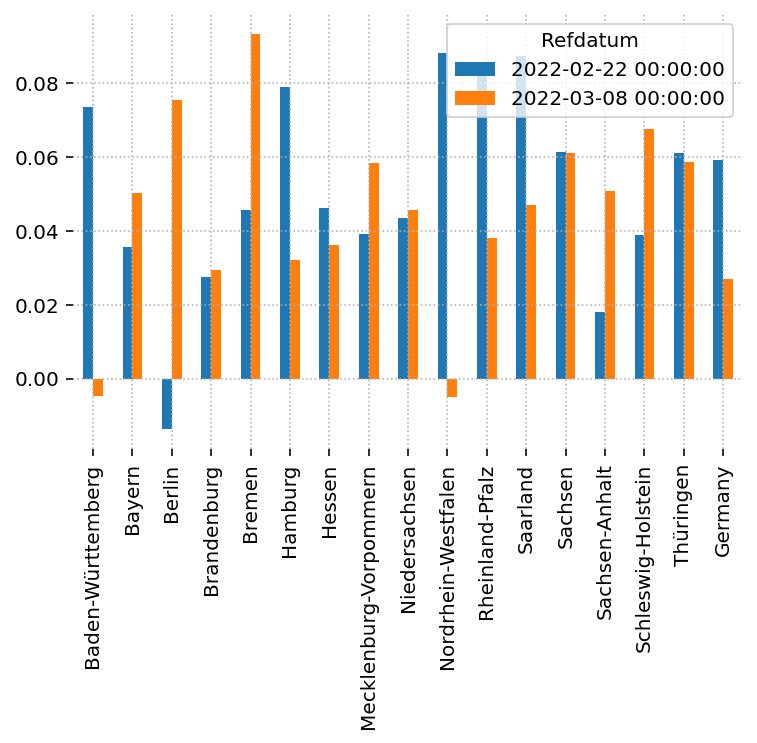

In [143]:
d.plot.bar()

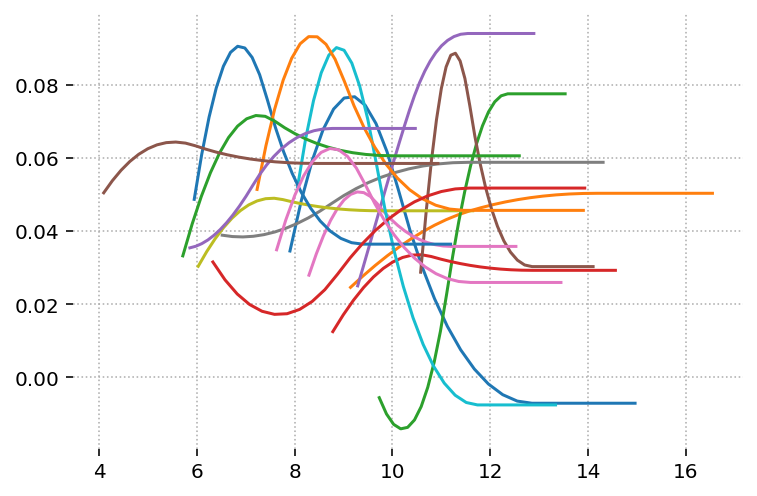

In [144]:
r = model.get_growth_rate_lineage(ltla=None).mean(0)[:,-28:,2]
x = λ[...,:,:3].sum(2).cumsum(1)[:,-28:] * 100
for i in range(r.shape[0]):
    plt.plot(x[i,:],r[i,:])

(18962.0, 19064.0)

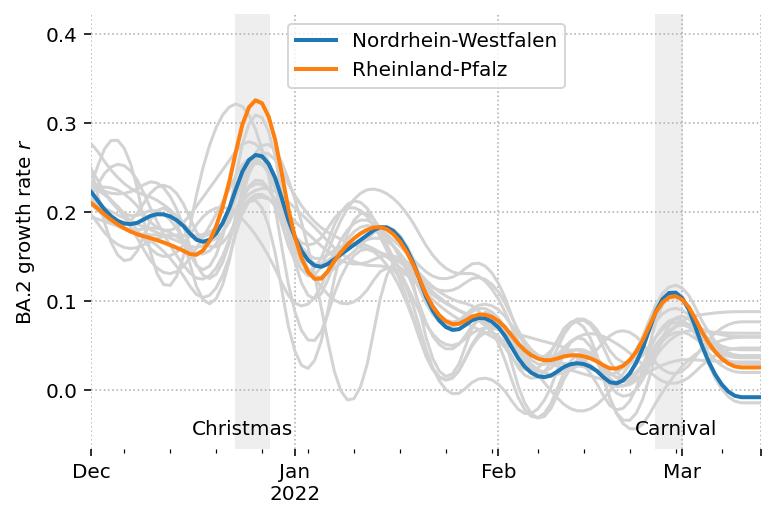

In [266]:
r = np.mean(model.get_growth_rate_lineage(ltla=None),0)[:,:,2]
r = pd.DataFrame(r.T[:-5], index=cases_land.columns[:-4].to_list(), columns=cases_land.index.to_list() + ["Germany"])
r.plot(c = 'lightgrey', alpha=1, legend=False)
r[["Nordrhein-Westfalen","Rheinland-Pfalz"]].plot( alpha=1, lw=2, ax=plt.gca())
#plt.legend("off")
plt.ylabel("BA.2 growth rate $r$")
plt.axvspan("2021-12-23","2021-12-28", color='#EEEEEE', zorder=0)
plt.axvspan("2022-02-25","2022-03-01", color='#EEEEEE', zorder=0)
plt.text("2021-12-24",-0.05,"Christmas", ha='center')
plt.text("2022-02-28",-0.05,"Carnival", ha='center')
plt.xlim(("2021-12-01",None))

In [64]:
from celluloid import Camera
from tqdm import tqdm
from matplotlib import colors


100%|██████████| 122/122 [00:42<00:00,  2.87it/s]


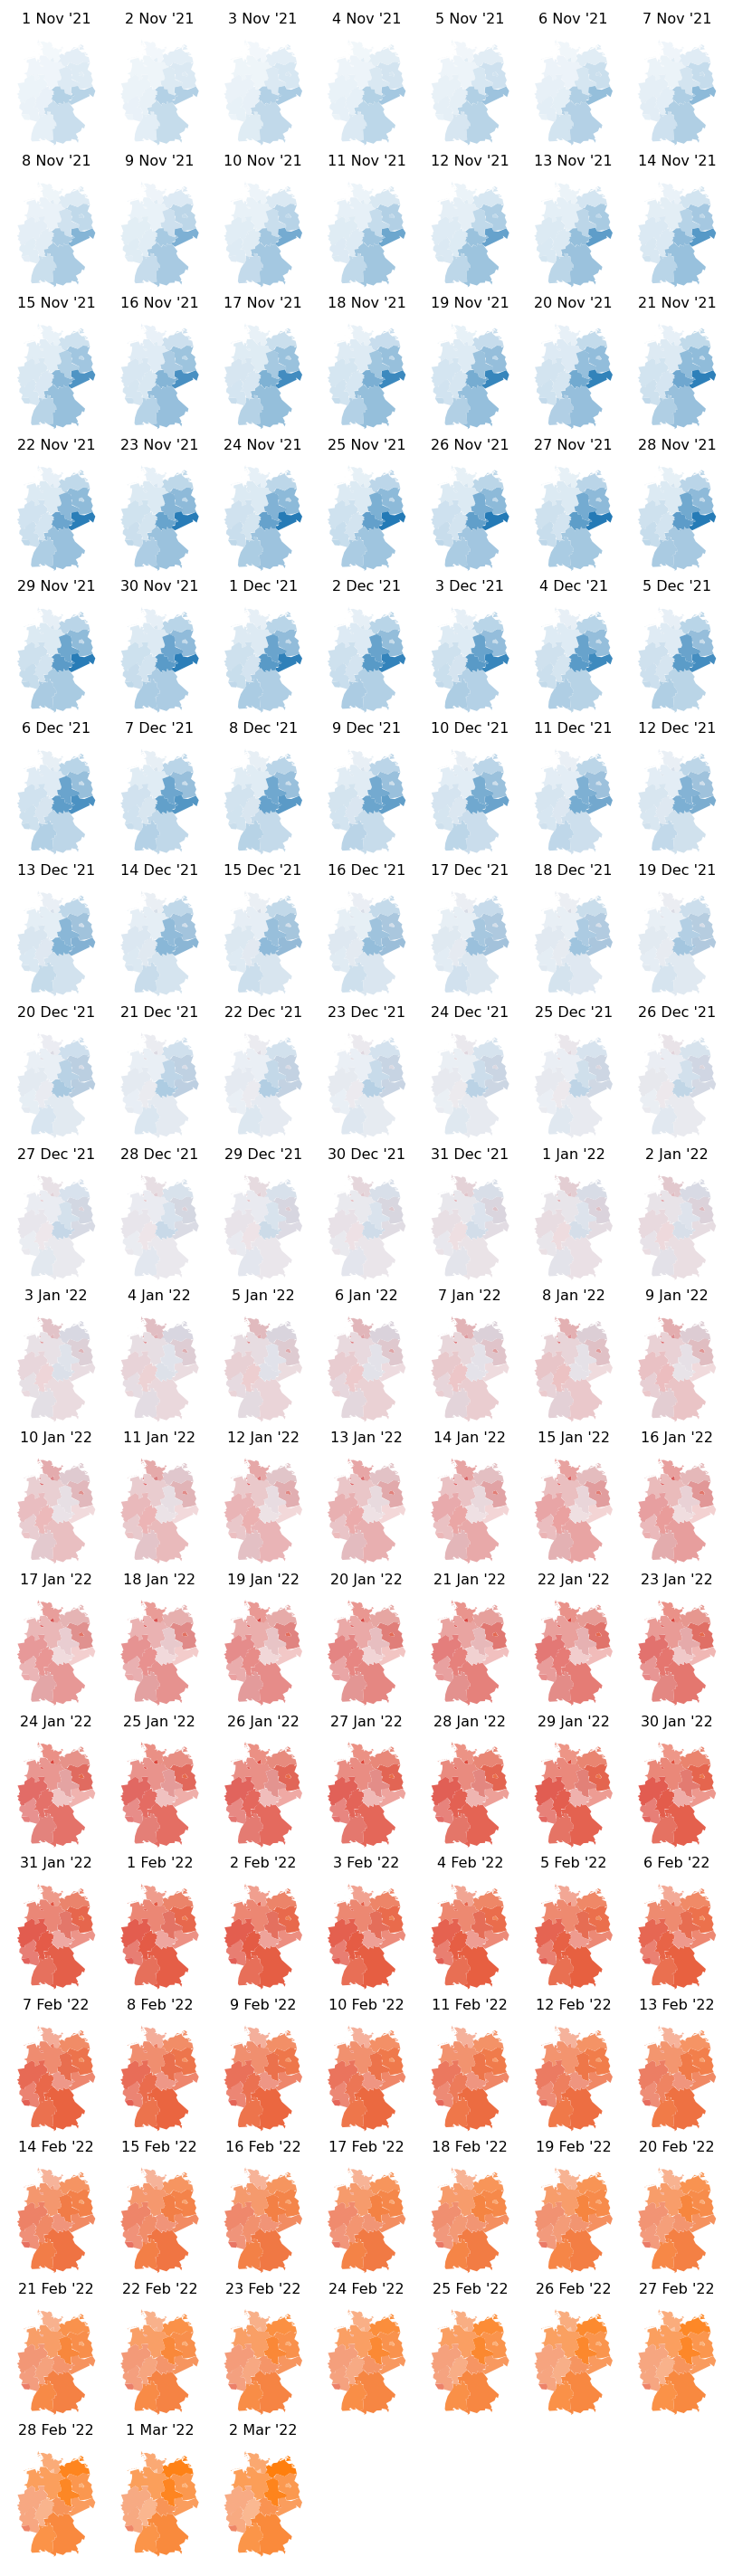

In [65]:
n = 7
m = (int(λ.shape[1]/7)+1)
fig, axs = plt.subplots(m,n, figsize=(7,10*m/n))
#camera = Camera(fig)
b0 = bl.copy().simplify(1e-1)
axs = axs.flatten()
for ax in axs:
    ax.axis("off")

    
def make_rgb_transparent(rgb, bg_rgb, alpha):
    return [alpha * c1 + (1 - alpha) * c2 for (c1, c2) in zip(rgb, bg_rgb)]

def alpha_to_color(alpha, c):
    c0 = []#(1,1,1)
    for x in alpha:
        cc = (1,1,1)
        for j, y in enumerate(x):
            cc = make_rgb_transparent(c[j ], cc, y)
        c0 += [cc]
    return c0

cols = [colors.colorConverter.to_rgb("C3"),
     colors.colorConverter.to_rgb("C3"),
     colors.colorConverter.to_rgb("C1"),
     colors.colorConverter.to_rgb("C0")]

for i in tqdm(range(λ.shape[1])): #λ.shape[1])
    ax = axs[i]
        
    #alpha = np.minimum(1, λ[:-1,i,[1,4]] * 700) #/λ.max()

    alpha = λ[:-1,i,[0,1,2,-1]]/λ.max()
    c = alpha_to_color(alpha, cols)

    ax.set_title((cases_land.columns[0] + np.timedelta64(i,"D")).strftime("%-d %b \'%y"), size=8)
    b0.plot(color=c, ax=ax)

    #bl.boundary.plot(color='w',lw=0.5, ax=ax)
    #de.boundary.plot(color='k',lw=1, ax=ax)
    #camera.snap()


In [66]:
f"{λ[:-1,-1,1] @ capita.values:0.0f}"

'37221'

In [67]:
λ.max()*700

1.4526477300739673

100%|██████████| 122/122 [07:36<00:00,  3.74s/it]


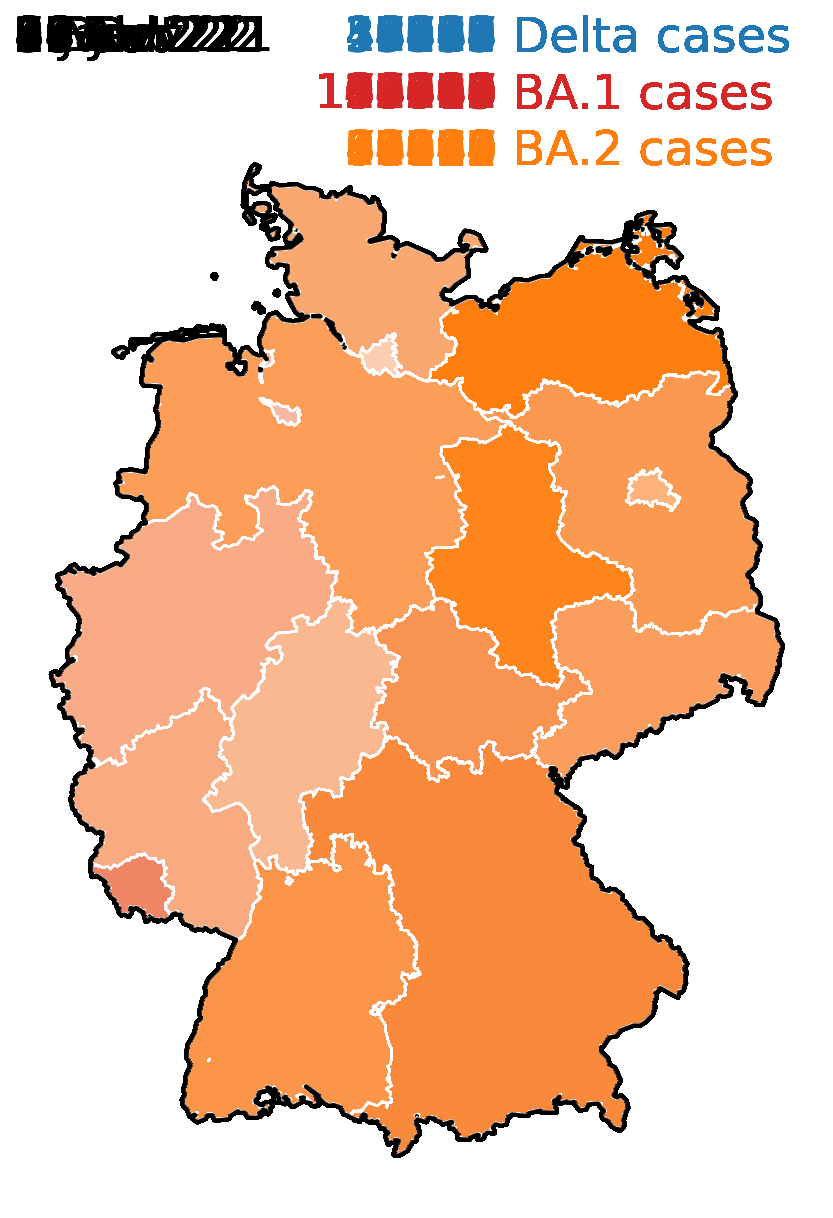

In [68]:
fig, ax = plt.subplots(1,1, figsize=(8,10.5), facecolor=None)
camera = Camera(fig)
b0 = bl.copy()#.simplify(1e-2)

ax.axis("off")

for i in tqdm(range(λ.shape[1])): #λ.shape[1])
    
    #alpha = np.minimum(1, λ[:-1,i,[1,4]] * 700) #/λ.max()
    alpha = λ[:-1,i,[0,1,2,-1]]/λ.max()
    c = alpha_to_color(alpha, cols)
    #c = [make_rgb_transparent(y, make_rgb_transparent(r, make_rgb_transparent(b, (1,1,1), x[2]), x[0]), x[1]) for x in alpha]
    b0.plot(color=c, ax=ax)

    #ax.set_title(cases_land.columns[i].strftime("%-d %b \'%y"), size=12)
    if i == 0:
        ax.set_ylim((None, ax.get_ylim()[0] + 1.05 * (ax.get_ylim()[1]-ax.get_ylim()[0])))
    
    ax.text(0.0, 1.01,  (cases_land.columns[0] + np.timedelta64(i,"D")).strftime("%-d %b \'%y"), size=24, transform=ax.transAxes)
    ax.text(0.6, 1.01,  f"{λ[:-1,i,-1] @ capita.values:0.0f}", color = "C0", size=24, transform=ax.transAxes, ha = 'right')
    ax.text(0.6, 0.96,  f"{λ[:-1,i,[0,1]].sum(-1) @ capita.values:0.0f}", color = "C3", size=24, transform=ax.transAxes, ha= 'right')
    ax.text(0.6, 0.91,  f"{λ[:-1,i,2] @ capita.values:0.0f}", color = "C1", size=24, transform=ax.transAxes, ha = 'right')
    ax.text(0.6, 1.01,  f" Delta cases", color = "C0", size=24, transform=ax.transAxes)
    ax.text(0.6, 0.96,  f" BA.1 cases", color = "C3", size=24, transform=ax.transAxes)
    ax.text(0.6, 0.91,  f" BA.2 cases", color = "C1", size=24, transform=ax.transAxes)

    bl.boundary.plot(color='w',lw=1, ax=ax)
    de.boundary.plot(color='k',lw=2, ax=ax)
    camera.snap()


In [69]:
animation = camera.animate(interval = 100, blit=True, repeat = False, repeat_delay=1000)

In [70]:
#import ffmpeg
from IPython.display import HTML
import re
HTML(re.sub("width=\"576\"","width=288",animation.to_html5_video()))

# UK analysis

In [209]:
import requests
cases_uk = pd.read_csv("https://api.coronavirus.data.gov.uk/v2/data?areaType=overview&metric=newCasesBySpecimenDate&format=csv", parse_dates=True, index_col=3)["newCasesBySpecimenDate"].sort_index().loc["2021-11-01":].iloc[:-1]

In [210]:
cases_uk

date
2021-11-01    45069
2021-11-02    37976
2021-11-03    35934
2021-11-04    33616
2021-11-05    30295
              ...  
2022-02-17    43559
2022-02-18    32333
2022-02-19    33861
2022-02-20    36757
2022-02-21    42078
Name: newCasesBySpecimenDate, Length: 113, dtype: int64

In [211]:
x = []
c = "United Kingdom"
for v in ['BA.1','BA.1.1', 'BA.2', 'BA.3', 'B.1.617.2*']:
    r = requests.get(f"https://lapis.cov-spectrum.org/gisaid/v1/sample/aggregated?fields=date&host=Human&country={c}&dateFrom=2021-11-01&dateTo={np.datetime64('today')}&pangoLineage={v}") #&dataVersion=1642092398
    d = pd.DataFrame(r.json()['data'])
    x.append(pd.DataFrame({v: d['count'].values}, index=pd.DatetimeIndex(d.date)).sort_index()[v])

genomes_uk = pd.DataFrame(x).T.fillna(0)#
genomes_uk = genomes_uk.loc[genomes_uk.index <= cases_uk.index.max(),:]
genomes_uk.sum(0)

BA.1          338473.0
BA.1.1        138324.0
BA.2           29613.0
BA.3              18.0
B.1.617.2*    372938.0
dtype: float64

In [212]:
genomes_uk = genomes_uk[genomes_uk.sum(1) > 100]

In [213]:
genomes_uk

BA.1  BA.1.1    BA.2  BA.3  B.1.617.2*
date                                                
2021-11-01     0.0     0.0     0.0   0.0      7781.0
2021-11-02     0.0     0.0     0.0   0.0      5999.0
2021-11-03     1.0     0.0     0.0   0.0      7031.0
2021-11-04     0.0     0.0     0.0   0.0      6415.0
2021-11-05     0.0     0.0     0.0   0.0      7034.0
...            ...     ...     ...   ...         ...
2022-02-12  1279.0  1889.0  1444.0   1.0         1.0
2022-02-13   635.0   983.0   856.0   0.0         1.0
2022-02-14   764.0  1270.0  1026.0   0.0         0.0
2022-02-15   368.0   617.0   593.0   0.0         1.0
2022-02-16    30.0    57.0    72.0   0.0         0.0

[108 rows x 5 columns]

In [214]:
genomes_uk["BA.1"][:"2021-11-18"] = 0
genomes_uk["BA.1.1"][:"2021-11-18"] = 0
genomes_uk["BA.2"][:"2021-12-18"] = 0

In [ ]:
date_split = np.datetime64("2021-12-14") + np.arange(0,8,2).astype("timedelta64[W]")#[np.datetime64("2021-12-12"), np.datetime64("2021-12-31")]
#bar[1,genomes_uk.index > d[1],:] = 0
#bar[2,genomes_uk.index <= d[1],:] = 0

In [216]:
date_split

array(['2021-12-14', '2021-12-28', '2022-01-11', '2022-01-25'],
      dtype='datetime64[D]')

In [217]:
foo = np.stack((len(date_split)+1) * [cases_uk["2021-11-01":].values], axis=0)
bar = np.stack((len(date_split)+1)  * [genomes_uk.values], axis=0)
for i, dd in enumerate(date_split):
    bar[i,genomes_uk.index > dd,:] = 0
    bar[i+1,genomes_uk.index <= dd,:] = 0


In [218]:
model_uk = MultiLineageTimeShift(
    foo, #cases_uk["2021-11-01":].values.reshape(1,-1),
    bar,    
    np.array([cases_uk.index.to_list().index(i) for i in genomes_uk.index]),
    np.repeat(67.22e6,len(date_split)+1),
    #auto_correlation=0.5,
    #linearize=True,
    arma = arma2,
    b_scale=0.05,
    b0_scale=0.5,
    c_scale=10.,
    beta_scale= np.append(10.,np.repeat(10., B0.shape[2]-1)),# np.concatenate([np.repeat(1., knots.num_long_basis), np.repeat(.1, knots.num_short_basis)]),
    tau=4.6,
    basis=B0, #knots.basis,
    shift=7,  
    alpha0=.01,
    alpha1=10000., 
    week=True,
    #model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=5), 'num_epochs':10000, 'lr':0.001, 'num_samples': 100}
    model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=10), 'num_epochs':10000, 'lr':0.005, 'lrd': 0.1 ** (1/10000), 'num_samples': 100}

)

In [219]:
model_uk.fit()

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:6576: UserWarning: Explicitly requested dtype float requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


KeyboardInterrupt: 

In [ ]:
plt.plot(model_uk.loss[2000:])
plt.xlabel('Epoch')
plt.ylabel('ELBO')

In [ ]:
import importlib
importlib.reload(gs.misc.misc)
importlib.reload(gs.misc)
from genomicsurveillance.misc import MultiLineageTimeShift, plot_lad, plot_growth_rates, get_transmissibility

In [ ]:
for j,i in enumerate(range(bar.shape[0]-1,-1, -1)):
    w = [0,1,2,4]#np.arange(genomes_uk.shape[1]) #if i == 2 else [0,2]
    plot_lad(model_uk, i, 
             #model_uk.cases, model_uk.lineages, np.array([cases_uk.index.to_list().index(i) for i in genomes_uk.index]), 
             start_date="2021-11-01", 
             show_start_date="2021-11-01",
            lin = w,
            labels = genomes_uk.columns[w],
            lin_colors=np.array(['C3','C4', "C1" ,"C9", "C0","C0"])[w],#, "C6", "C1","C8"],
            #labels=[alias(y) if alias(y) != "AY.121" else "Orf3a:202L" for y in x],#["B.1.1.7", 'Delta', "AY.4", 'B.1.617.2.5', "B.1.177"],
            case_color="grey",
            case_markercolor="lightgrey",
                figsize=(5,6),
                prop_err=False,
            clip_to_lineage_data = True,
             add = j,
            bleed_left = 1,
             bleed_right= 5 if j == 0 else 1,
             show_Rt = False,
             plot_s= True,
             plot_r = True
            )

ax=plt.gcf().get_axes()
    
ax[0].set_title("United Kingdom", size=12, weight='bold')
#ax[0].set_yscale("log")

ax[1].set_yscale("logit")
ax[1].set_ylim((1e-4,1-1e-2))
ax[2].set_ylim((-.2,.45))
ax[1].legend(facecolor='white')
#ax[2].legend().remove()
ax[2].legend(loc='lower left')
ax[3].grid(False)
for i,a in enumerate(ax[:-1]):
    a.grid(ls=":")
    for dd in date_split:
        x = dd 
        if i ==2:
            x -= np.timedelta64(int(model.tau), "D")
            a.axvline(x, ls=":", color='k', lw=0.5)
#f = ax[2].xaxis.get_major_formatter()
#ax[1].xaxis.set_major_formatter(f)
#ax[1].set_xticklabels(ax[2].get_xticklabels(), visible=True)
#plt.setp(ax[1].get_xticklabels(),visible=True)
#plt.delaxes(ax[3])
#plt.delaxes(ax[0])
#ax[1].xaxis.set_tick_params(labelbottom=True)

#ax[1].xaxis.set_major_formatter(f)


In [ ]:
## import importlib
importlib.reload(gs.misc.misc)
importlib.reload(gs.misc)
from genomicsurveillance.misc import MultiLineageTimeShift, plot_lad, plot_growth_rates

In [ ]:
plt.figure(figsize=(4,4))
plot_growth_rates(model_uk, genomes_uk.columns.to_list(), color=["C0","None"], baseline="BA.1")


In [ ]:
bar.shape

In [ ]:
ax=plt.gcf().get_axes()

In [ ]:
ax

## Germany

In [358]:
foo = np.stack((len(date_split)+1) * [CC[-1]], axis=0)
bar = np.stack((len(date_split)+1)  * [GG[-1]], axis=0)
for i, dd in enumerate(date_split):
    bar[i,genomes.index.levels[1] > dd + np.timedelta64(2,"D"),:] = 0
    bar[i+1,genomes.index.levels[1] < dd - np.timedelta64(1,"D"),:] = 0
bar[0,:,2] = 0

In [359]:
model_de = MultiLineageTimeShift(
    foo, #cases_uk["2021-11-01":].values.reshape(1,-1),
    bar,    
    seq_index,
    np.repeat(capita.values.sum().reshape(1),len(date_split)+1),
    #auto_correlation=0.5,
    #linearize=True,
    arma = arma2,
    b_scale=0.05,
    b0_scale=0.5,
    c_scale=5,
    beta_scale= np.append(10.,np.repeat(10., B0.shape[2]-1)),# np.concatenate([np.repeat(1., knots.num_long_basis), np.repeat(.1, knots.num_short_basis)]),
    tau=4.6,
    basis=B0, #knots.basis,
    shift=7,  
    alpha0=.01,
    alpha1=10000., 
    week=True,
    #model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=5), 'num_epochs':10000, 'lr':0.001, 'num_samples': 100}
    model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=10), 'num_epochs':10000, 'lr':0.005, 'lrd': 0.1 ** (1/10000), 'num_samples': 100}

)

In [360]:
model_de.fit()

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:6576: UserWarning: Explicitly requested dtype float requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


SVI step 0 / 10,000 | 0 %
SVI step 1,000 / 10,000 | 10 %
SVI step 2,000 / 10,000 | 20 %
SVI step 3,000 / 10,000 | 30 %
SVI step 4,000 / 10,000 | 40 %
SVI step 5,000 / 10,000 | 50 %
SVI step 6,000 / 10,000 | 60 %
SVI step 7,000 / 10,000 | 70 %
SVI step 8,000 / 10,000 | 80 %
SVI step 9,000 / 10,000 | 90 %


Text(0, 0.5, 'ELBO')

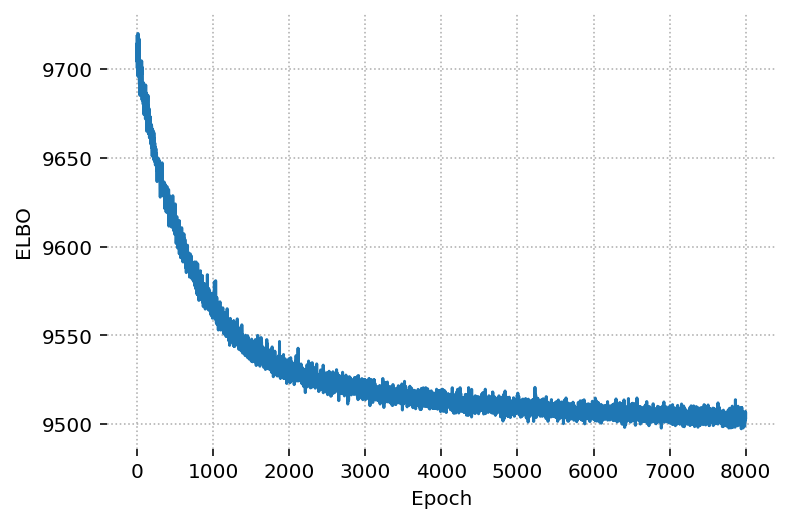

In [361]:
plt.plot(model_de.loss[2000:])
plt.xlabel('Epoch')
plt.ylabel('ELBO')

In [362]:
import importlib
importlib.reload(gs.misc.misc)
importlib.reload(gs.misc)
from genomicsurveillance.misc import MultiLineageTimeShift, plot_lad, plot_growth_rates, get_transmissibility

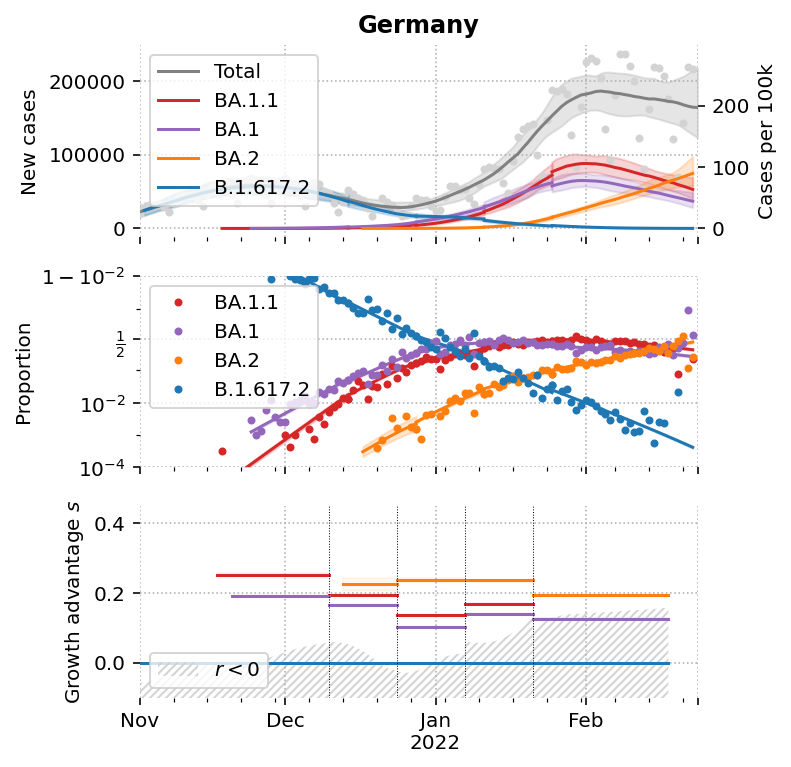

In [363]:
for j,i in enumerate(range(bar.shape[0]-1,-1, -1)):
    w = [1,0,2,5]#np.arange(genomes.shape[1]) #if i == 2 else [0,2]
    plot_lad(model_de, i, 
             #model_uk.cases, model_uk.lineages, np.array([cases_uk.index.to_list().index(i) for i in genomes_uk.index]), 
             start_date="2021-11-01", 
             show_start_date="2021-11-01",
            lin = w,
            labels = genomes.columns[w],
            lin_colors=np.array(['C4','C3', "C1" ,"C9", "C0","C0"])[w],#, "C6", "C1","C8"],
            #labels=[alias(y) if alias(y) != "AY.121" else "Orf3a:202L" for y in x],#["B.1.1.7", 'Delta', "AY.4", 'B.1.617.2.5', "B.1.177"],
            case_color="grey",
            case_markercolor="lightgrey",
                figsize=(5,6),
                prop_err=False,
            clip_to_lineage_data = True,
             add = j,
            bleed_left = -1,
             bleed_right= 5 if j == 0 else -1,
             show_Rt = False,
             plot_s= True,
             plot_r = True
            )

ax=plt.gcf().get_axes()
    
ax[0].set_title("Germany", size=12, weight='bold')

ax[1].set_yscale("logit")
ax[1].set_ylim((1e-4,1-1e-2))
ax[2].set_ylim((-.1,.45))
ax[1].legend(facecolor='white')
#ax[2].legend().remove()
ax[2].legend(loc='lower left')#.remove()
ax[3].grid(False)
for i,a in enumerate(ax[:-1]):
    a.grid(ls=":")
    for dd in date_split:
        x = dd 
        if i ==2:
            x -= np.timedelta64(int(model.tau), "D")
            a.axvline(x, ls=":", color='k', lw=0.5)
plt.delaxes(ax[3])



In [364]:
pd.DataFrame(get_transmissibility(model_de), columns=genomes.columns)

lineage      BA.1    BA.1.1      BA.2      BA.3     Other  B.1.617.2
0        0.191420  0.252462  0.021681  0.042103  0.074427        0.0
1        0.165376  0.194052  0.223760  0.042103  0.086572        0.0
2        0.102504  0.135664  0.237153  0.133593  0.063556        0.0
3        0.140669  0.169088  0.236354 -0.056527 -0.127477        0.0
4        0.124018  0.126526  0.194083  0.188843  0.192795        0.0

n  Growth rate r to ancestor      +/-   \
Lineage                                                  
BA.1        64760                   0.018187  0.031125   
BA.1.1      62333                   0.018127  0.045396   
BA.2        14991                   0.021681  0.017539   
BA.3           25                   0.042103  0.110309   
Other         274                   0.031535  0.103882   
B.1.617.2  137593                   0.000000  0.000000   

           Growth rate r to baseline BA.1       +/-  
Lineage                                              
BA.1                             0.000000  0.031125  
BA.1.1                           0.030761  0.045396  
BA.2                             0.078040  0.017539  
BA.3                            -0.056161  0.110309  
Other                           -0.086823  0.103882  
B.1.617.2                       -0.144798  0.000000

/Users/mg14/Downloads/desh-data/genomicsurveillance/misc/misc.py:876: RuntimeWarning: divide by zero encountered in log
  ax3.set_ylabel("Approximate $R_t$ ratio")


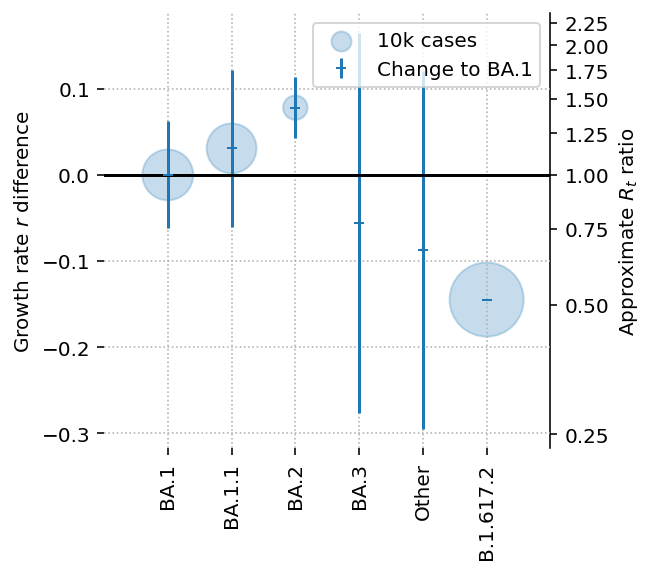

In [365]:
plt.figure(figsize=(4,4))
plot_growth_rates(model_de, genomes.columns.to_list(), color=["C0","None"], baseline="BA.1")


## Denmark

In [ ]:
cases_dk = pd.read_csv("../overvaagningsdata-dashboard-covid19-31012022-40ip/Regionalt_DB/08_bekraeftede_tilfaelde_pr_dag_pr_regions.csv", index_col=[0,1],parse_dates=True, encoding='latin_1', sep=";").sum(level=1).loc["2021-11-01":].iloc[:-1,0]

In [ ]:
cases_dk

In [ ]:
x = []
c = "Denmark"
for v in ['BA.1','BA.1.1', 'BA.2', 'BA.3', 'B.1.617.2*']:
    r = requests.get(f"https://lapis.cov-spectrum.org/gisaid/v1/sample/aggregated?fields=date&host=Human&country={c}&dateFrom=2021-11-01&dateTo={np.datetime64('today')}&pangoLineage={v}") #&dataVersion=1642092398
    d = pd.DataFrame(r.json()['data'])
    try:
        x.append(pd.DataFrame({v: d['count'].values}, index=pd.DatetimeIndex(d.date)).sort_index()[v])
    except:
        pass


genomes_dk = pd.DataFrame(x).T.fillna(0)#
genomes_dk = genomes_dk.loc[genomes_dk.index <= cases_dk.index.max(),:]
genomes_dk.sum(0)

In [ ]:
date_split = np.datetime64("2021-12-14") + np.arange(0,6,2).astype("timedelta64[W]")#[np.datetime64("2021-12-12"), np.datetime64("2021-12-31")]

In [ ]:
foo = np.stack((len(date_split)+1) * [cases_dk["2021-11-01":].values], axis=0)
bar = np.stack((len(date_split)+1)  * [genomes_dk.values], axis=0)
for i, dd in enumerate(date_split):
    bar[i,genomes_dk.index > dd,:] = 0
    bar[i+1,genomes_dk.index <= dd,:] = 0


In [ ]:
model_dk = MultiLineageTimeShift(
    foo, #cases_uk["2021-11-01":].values.reshape(1,-1),
    bar,    
    np.array([cases_dk.index.to_list().index(i) for i in genomes_dk.index]),
    np.repeat(5.831e6,len(date_split)+1),
    #auto_correlation=0.5,
    #linearize=True,
    arma = arma2,
    b_scale=0.1,
    b0_scale=0.5,
    c_scale=5,
    beta_scale= np.append(10.,np.repeat(10., B0.shape[2]-1)),# np.concatenate([np.repeat(1., knots.num_long_basis), np.repeat(.1, knots.num_short_basis)]),
    tau=4.6,
    basis=B0, #knots.basis,
    shift=7,  
    alpha0=.01,
    alpha1=10000., 
    week=True,
    #model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=5), 'num_epochs':10000, 'lr':0.001, 'num_samples': 100}
    model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=10), 'num_epochs':12000, 'lr':0.005, 'lrd': 0.1 ** (1/10000), 'num_samples': 100}

)

In [ ]:
foo.shape

In [ ]:
model_dk.fit()

In [ ]:
plt.plot(model_dk.loss[2000:])
plt.xlabel('Epoch')
plt.ylabel('ELBO')

In [ ]:
import importlib
importlib.reload(gs.misc.misc)
importlib.reload(gs.misc)
from genomicsurveillance.misc import MultiLineageTimeShift, plot_lad, plot_growth_rates, get_transmissibility

In [ ]:
for j,i in enumerate(range(bar.shape[0]-1,-1, -1)):
    w = [0,1,2,3]#np.arange(genomes.shape[1]) #if i == 2 else [0,2]
    plot_lad(model_dk, i, 
             #model_uk.cases, model_uk.lineages, np.array([cases_uk.index.to_list().index(i) for i in genomes_uk.index]), 
             start_date="2021-11-01", 
             show_start_date="2021-11-01",
            lin = w,
            labels = genomes_dk.columns[w],
            lin_colors=np.array(['C3','C4', "C1" ,"C0", "C0","C0"])[w],#, "C6", "C1","C8"],
            #labels=[alias(y) if alias(y) != "AY.121" else "Orf3a:202L" for y in x],#["B.1.1.7", 'Delta', "AY.4", 'B.1.617.2.5', "B.1.177"],
            case_color="grey",
            case_markercolor="lightgrey",
                figsize=(5,6),
                prop_err=False,
            clip_to_lineage_data = True,
             add = j,
            bleed_left = 1,
             bleed_right=3 if j ==0 else 1,
             show_Rt = False,
             plot_s= True
            )

ax=plt.gcf().get_axes()
    
ax[0].set_title("Denmark", size=12, weight='bold')

#ax[1].set_yscale("logit")
#ax[1].set_ylim((1e-4,1-1e-2))
ax[2].set_ylim((-.1,.45))
ax[1].legend().remove()
ax[1].legend(facecolor='white')
ax[2].legend(loc='lower right')#.remove()
ax[3].grid(False)
for i,a in enumerate(ax[:-1]):
    a.grid(ls=":")
    for dd in date_split:
        x = dd 
        if i ==2:
            x -= np.timedelta64(int(model.tau), "D")
            a.axvline(x, ls=":", color='k', lw=0.5)
plt.delaxes(ax[3])


In [ ]:
(bar[-1,-15:] )

In [ ]:
genomes_dk

In [ ]:
plt.figure(figsize=(4,4))
plot_growth_rates(model_dk, genomes_dk.columns.to_list(), color=["C0","None"], baseline="BA.1")
